In [1]:
# Import Packages
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 
import metpy 
from metpy.units import units 
import metpy.calc as mpcalc
from metpy.plots import SkewT
import os 
import wrf 
import glob
import pandas as pd 
from IPython.display import HTML, display 
import imageio
from itertools import product
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import random as random 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
# Establish Model Path
model_path = '/storage/group/pmm116/default/bsh5393/cm1sims/'

# Simulation Paths
sim_paths = sorted(glob.glob(model_path + '*SIM*'))
# Sorting function
sim_paths = sorted(sim_paths, key=lambda x: int(x.split('SIM')[1].split('_')[0]))

# Simulation Names
sim_names = sorted(os.listdir(sim_paths[0]))
sim_names = [name for name in sim_names if 'cm1out_00' in name]

# Actual Names of Each Run
run_names = sorted(os.listdir(model_path))
#run_names.remove('cm1test')
#run_names.remove('cm1test2')
#run_names.remove('test_101158')
run_names = sorted(run_names, key=lambda x: int(x.split('SIM')[1].split('_')[0]))

# Create Global Variables
sample_sim = xr.open_dataset(sim_paths[0]+ '/' + sim_names[0])

# Grid Points
x_grid = sample_sim['xf']
y_grid = sample_sim['yf']
z_grid = sample_sim['zf']

# Scalar Points
x_data = sample_sim['xh']
y_data = sample_sim['yh']
z_data = sample_sim['zh']

# Time Array
time = np.linspace(0, 120, 25, dtype='int')

In [ ]:
# Variable Names for data retrieval
var_names = ['winterp','vinterp', 'uinterp', 'dbz', 'zvort']

# Dictionary of All Simulation Data
simulation_winterp = {}
simulation_vinterp = {}
simulation_uinterp = {}
simulation_grwind = {}
simulation_dbz = {}
simulation_zvort = {}

# Create a loop that organizes the data we need 
for sim in tqdm(range(len(sim_paths))):
    # empty list to store data. 
    # order of variables is that of var names
    winterp = []
    vinterp = []
    uinterp = []
    gr_wind = []
    dbz = []
    zvort = []
    for t in np.arange(8, len(sim_names),1):
        # w-interp 
        winterp.append(xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['winterp'][0])
        
        # v-interp 
        vinterp.append(xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['vinterp'][0])
        
        # u-interp 
        uinterp.append(xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['uinterp'][0])
        
        # ground relative winds
        u = xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['uinterp'][0][0]+12.2
        v = xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['vinterp'][0][0]+12.5
        gr_wind.append((u**2 + v**2)**.5)
        
        # reflectivty
        dbz.append(xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['dbz'][0])
        
        # vertical vorticity
        zvort.append(xr.open_dataset(sim_paths[sim] + '/' + sim_names[t])['zvort'][0])
    
    # save reorganized data as a dictionary
    simulation_winterp[run_names[sim]] = winterp
    simulation_vinterp[run_names[sim]] = vinterp
    simulation_uinterp[run_names[sim]] = uinterp
    simulation_dbz[run_names[sim]] = dbz
    simulation_zvort[run_names[sim]] = zvort
    simulation_grwind[run_names[sim]] = gr_wind

# TLV Tracking at 5-min Resolution

In [ ]:
# Find the Vorticity Max (Might Need to Tweak This such that it looks for points that are jointly over
# .25 s^-1 and ground relative winds exceeding 29 m/s)
'Next Step: Need to compute bunkers storm motion'
simulation_tor_tracker = {}

# Create a loop that organizes the data we need 
for sim in tqdm(range(len(sim_paths))):
    # empty array to store data. 
    indices = np.zeros((len(sim_names)-8,2), dtype='int')
    vort_values = np.zeros(len(sim_names)-8)
    gr_wind = np.zeros(len(sim_names)-8)
    for t in np.arange(0, len(sim_names)-8,1):
        
        # Find colocated points with GR_wind > 29 m/s and Vert. Vorticity > 0.25 1/s
        # Find Ground Relative Wind 
        offset_u = 12.2 
        offset_v = 12.5
        u = simulation_uinterp[run_names[sim]][t][0] + offset_u
        v = simulation_vinterp[run_names[sim]][t][0] + offset_v
        grwind = (u**2 + v**2)**0.5
        # Vertical Vorticity
        vertvort = simulation_zvort[run_names[sim]][t][0]
        
        # Find colocated points 
        condition = (grwind > 29) & (vertvort > 0.25)
        ind = np.column_stack(np.where(condition))
        
        # If there are matches, find the values
        if ind.size != 0:
            indices[t] = ind[0]
            vort_values[t] = simulation_zvort[run_names[sim]][t][0].isel(yh=int(indices[t][0]), 
                                                              xh=int(indices[t][1])).values
            gr_wind[t] = grwind.isel(yh=int(indices[t][0]), xh=int(indices[t][1])).values
        
        # If there are no matches, enter NaN values
        if ind.size == 0:
            gr_wind[t] = np.nan
            vort_values[t] = np.nan
            indices[t] = [0, 0]
        
        
    # Store the indices and the value
    simulation_tor_tracker[run_names[sim]] = [np.asarray(indices, dtype='int'), vort_values, gr_wind]

In [ ]:
# Assign Ratings Based on GR Wind Values 
# Rough Enhanced Fujita Scale Wind 
EF0_low = 26 #29
EF0_high = 34 #38 
EF1_low = 34 #38
EF1_high = 44 #49
EF2_low = 44 #49
EF2_high = 54 #60
EF3_low = 54 #60
EF3_high = 65# 73
EF4_low = 65# 73
EF4_high = 80 #89
EF5 = 80 #89


# Go through simulation_tor_tracker and assign ratings 
simulation_tor_ratings = {}
for sim in tqdm(range(len(run_names))):
    ratings = np.empty((len(simulation_tor_tracker[run_names[sim]][2])), dtype='<U10')
    for t in range(len(simulation_tor_tracker[run_names[0]][0])):
        # grab gr wind value
        gr_wind = simulation_tor_tracker[run_names[sim]][2][t]
        
        # EF0 Criteria
        if (gr_wind > EF0_low) & (gr_wind < EF0_high):
            ratings[t] = 'EF0'
            
        # EF1 Criteria
        if (gr_wind > EF1_low) & (gr_wind < EF1_high):
            ratings[t] = 'EF1'
            
        # EF2 Criteria
        if (gr_wind > EF2_low) & (gr_wind < EF2_high):
            ratings[t] = 'EF2'
            
        # EF3 Criteria
        if (gr_wind > EF3_low) & (gr_wind < EF3_high):
            ratings[t] = 'EF3'
       
        # No Tornado
        if (gr_wind == np.nan):
            ratings[t] = 'None'
    
    # save ratings
    simulation_tor_ratings[run_names[sim]] = ratings
    


In [10]:
simulation_tor_ratings

{'SIM1_10341': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM2_110061': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM3_111210': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM4_1285': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM5_13477': array(['', '', '', '', '', '', 'EF0', '', '', '', '', '', '', '', '', '',
        ''], dtype='<U10'),
 'SIM6_17963': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM7_23050': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U10'),
 'SIM8_26183': array(['', '', '', '', '', '', '', '', '', '', '', '', 'EF0', '', '', '',
        ''], dtype='<U10'),
 'SIM9_28488': array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

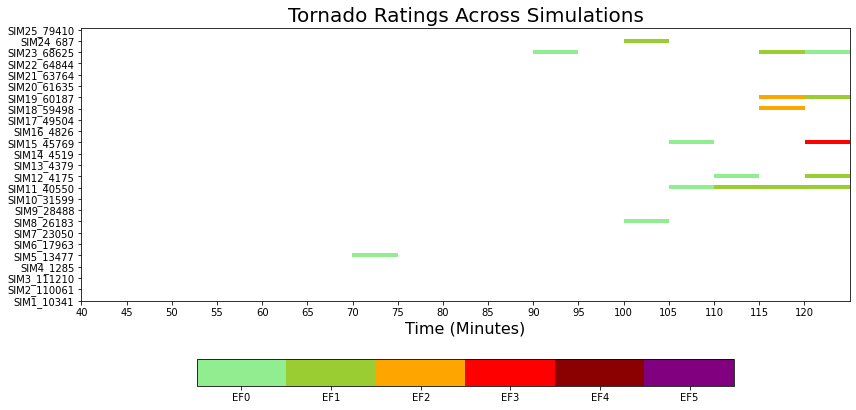

In [11]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightgreen",
    "EF1": "yellowgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "darkred",
    "EF5": "purple"
}

# Convert simulation_tor_ratings to a numerical grid for plotting
simulation_names = list(simulation_tor_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(simulation_tor_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(simulation_tor_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(simulation_names)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=17)  # 17 intervals for 5-min steps from 40 to 120
xtick_labels = [str(i) for i in range(40, 121, 5)]  # Generate labels from 40 to 120 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=16)
ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()
plt.show()

100%|██████████| 25/25 [00:00<00:00, 368.78it/s]


(0.0, 10.0)

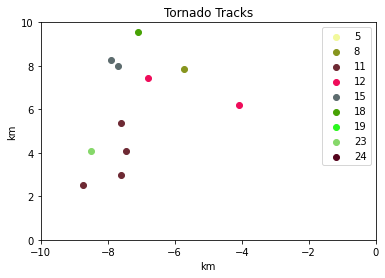

In [14]:
# Plot for TLV tracks

fig = plt.figure()
added_labels = set()  # To track added labels

for sim in tqdm(range(len(run_names))):
    # Choose a Random Color For Each Simulation
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    label = f'{sim+1}'
    for x in range(len(simulation_tor_tracker[run_names[sim]][0])):
        if (simulation_tor_tracker[run_names[sim]][0][x, 1] != 0) and (simulation_tor_tracker[run_names[sim]][0][x, 0] != 0):
            if label not in added_labels:  # Add label only once
                plt.scatter(
                    x_data[simulation_tor_tracker[run_names[sim]][0][x, 1]], 
                    y_data[simulation_tor_tracker[run_names[sim]][0][x, 0]], 
                    color=color, 
                    #marker = '_',
                    label=label
                )
                added_labels.add(label)
            else:
                plt.scatter(
                    x_data[simulation_tor_tracker[run_names[sim]][0][x, 1]], 
                    y_data[simulation_tor_tracker[run_names[sim]][0][x, 0]], 
                    color=color
                    #marker = '_'
                )
# Global Cosmetics
plt.legend()
plt.xlabel('km')
plt.ylabel('km')
plt.title('Tornado Tracks')
plt.xlim(-10,0)
plt.ylim(0,10)


# Tornado Tracking using CM1out_stats.nc File: Wind is derived from Burgers-Rott Vortex Theory (Pressure is the only criteria)

In [6]:
# This Cell Computes Max Wind for associate pressure differentials
def comp_velo(sim_path, psfcmin):
    
    # define mean pressure (need to interpolate down to the surface since the lowest model level is 7.5 m)
    
    # read in first 3 pressure levels
    press = xr.open_dataset(sim_path + '/' 
                                + sim_names[0])['prs'].isel(time=0, zh = slice(0,3), yh = 0, xh = 0).values
    # constants of taylor approximation/expansion
    c1 = 1.875
    c2 = -1.25
    c3 = 0.375
    
    # compute mean surface pressure
    mean_pres = c1*press[0] + c2*press[1] + c3*press[2]
    
    # define density 
    rho = 1.16 # kg/m^3
    
    # Compute Pressure Differential
    diff_pres = np.abs(mean_pres-psfcmin)
    
    # compute velocity
    max_v = np.sqrt(diff_pres/rho)
    
    return max_v;

In [6]:
# Determine the pressure deficit thresholds for EF-scale wind thresholds
old = [26, 34, 44, 54, 65, 80] # old EF-scale
for i in range(len(old)):
    print(((old[i]**2)*1.16)/100)

7.8416
13.409599999999998
22.4576
33.8256
49.01
74.24


# Revised For MS


100%|██████████| 241/241 [00:00<00:00, 2952.18it/s]


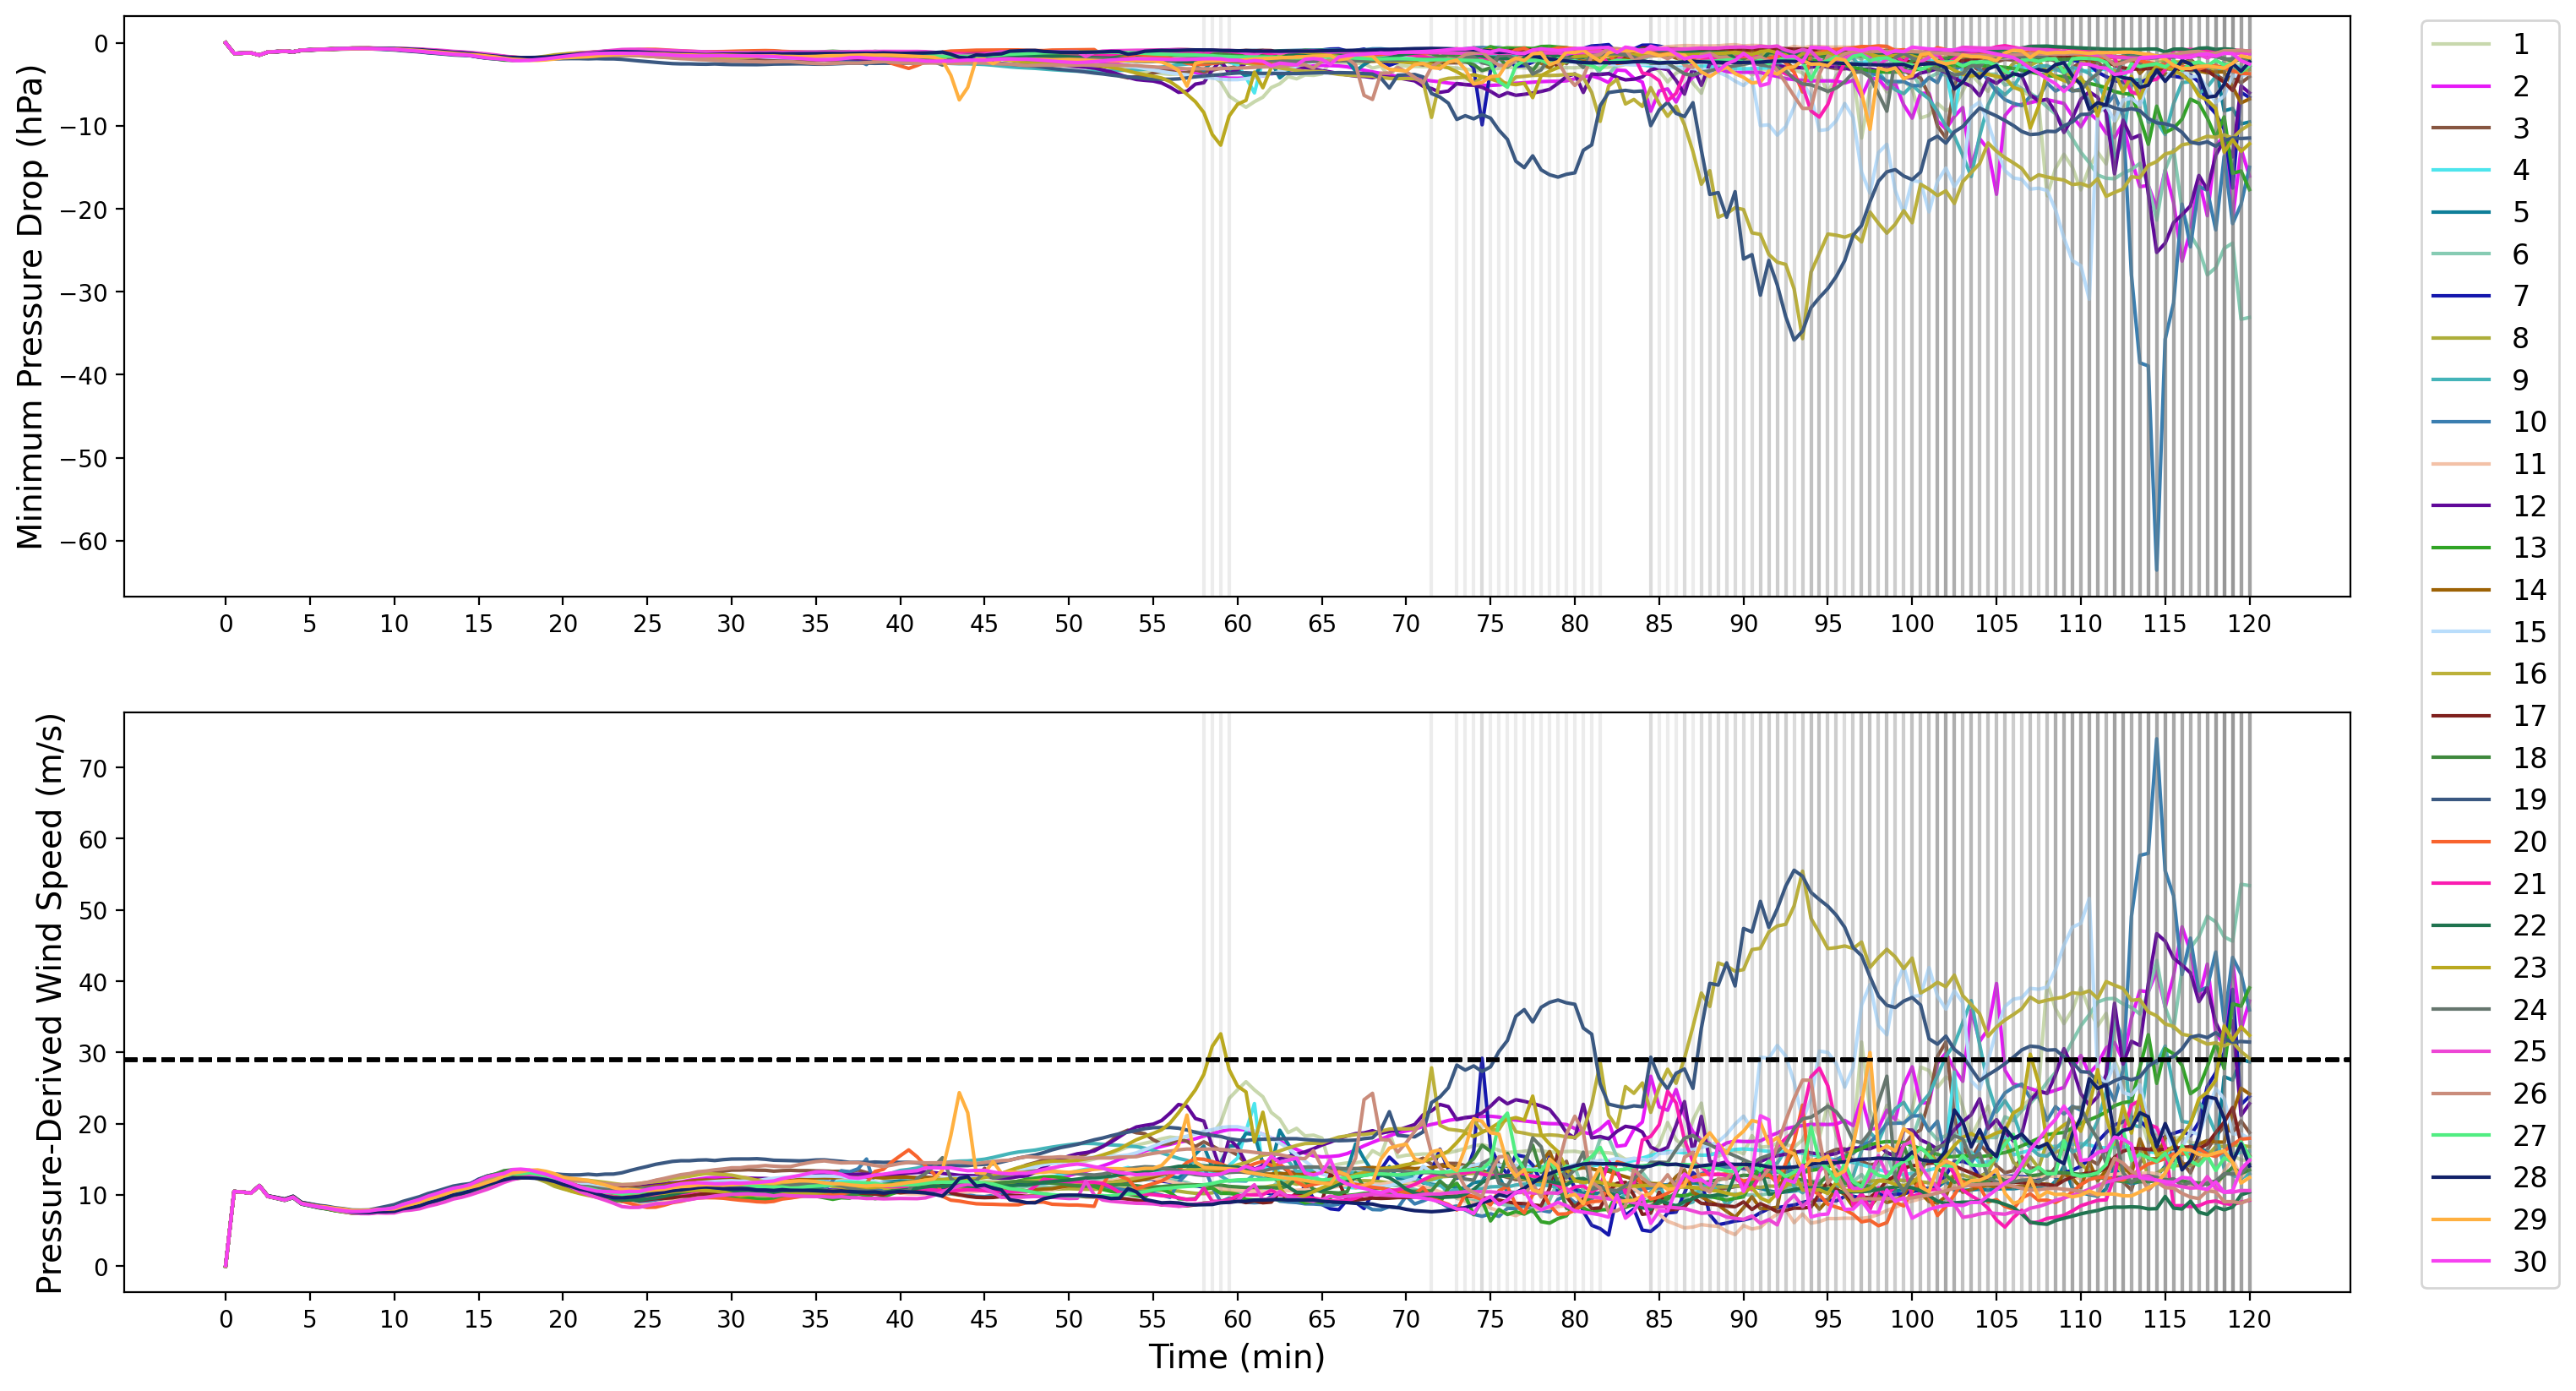

In [7]:
# Create Plot that shows the pressure driven max velocity

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize=(17,10), dpi = 200)  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    #gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    #vort = stats['vortsfc']
    min_press = stats['psfcmin']
    max_velo = comp_velo(sim_paths[x], min_press)
    # read in first 3 pressure levels
    press = xr.open_dataset(sim_paths[x] + '/' 
                                + sim_names[0])['prs'].isel(time=0, zh = slice(0,3), yh = 0, xh = 0).values
    # constants of taylor approximation/expansion
    c1 = 1.875
    c2 = -1.25
    c3 = 0.375
    
    # compute mean surface pressure
    mean_press = c1*press[0] + c2*press[1] + c3*press[2]
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(max_velo))):
        if (max_velo[t] >= 26):
            axs[0].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            
    # Top Plot: Vertical Vorticity exceeding .5 m/s
    #axs[0].plot(time_ind, vort, color = color, label = f'Sim. {x+1}')
    #axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    #axs[0].set_ylabel('Maximum Surface Vert. Vorticity ($s^{-1}$)')
    # plot axhline for tornadic threshold
    #axs[0].axhline(y = 0.5, linestyle='--', color = 'k')
    #axs[0].set_xticks(np.arange(0,121,5))
    #axs[0].set_ylim(0,0.6)
    
    # Top Plot: Min Surface Pressure
    axs[0].plot(time_ind, (min_press- mean_press)/100, color = color, label = f'{x+1}')
    axs[0].legend(loc='center right',  bbox_to_anchor=(.8, -0.6, 0.3, 1), fontsize = 12)
    axs[0].set_ylabel('Minimum Pressure Drop (hPa)', fontsize = 14)
    axs[0].set_xticks(np.arange(0,121,5))
    #axs[0].set_ylim(-10)
    
     # Bottom Plot: Max wind speed derived from minimum surface pressure
    axs[1].plot(time_ind, max_velo, color = color, label = f'{x+1}')
    #axs[0].legend()
    axs[1].set_ylabel('Pressure-Derived Wind Speed (m/s)', fontsize = 14)
    axs[1].set_xlabel('Time (min)', fontsize = 14)
    # plot axhline for tornadic threshold
    axs[1].axhline(y=29, linestyle='--', color = 'k')
    axs[1].set_xticks(np.arange(0,121,5))
    
    # Title the Figure
    #plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)

100%|██████████| 241/241 [00:00<00:00, 2974.79it/s]


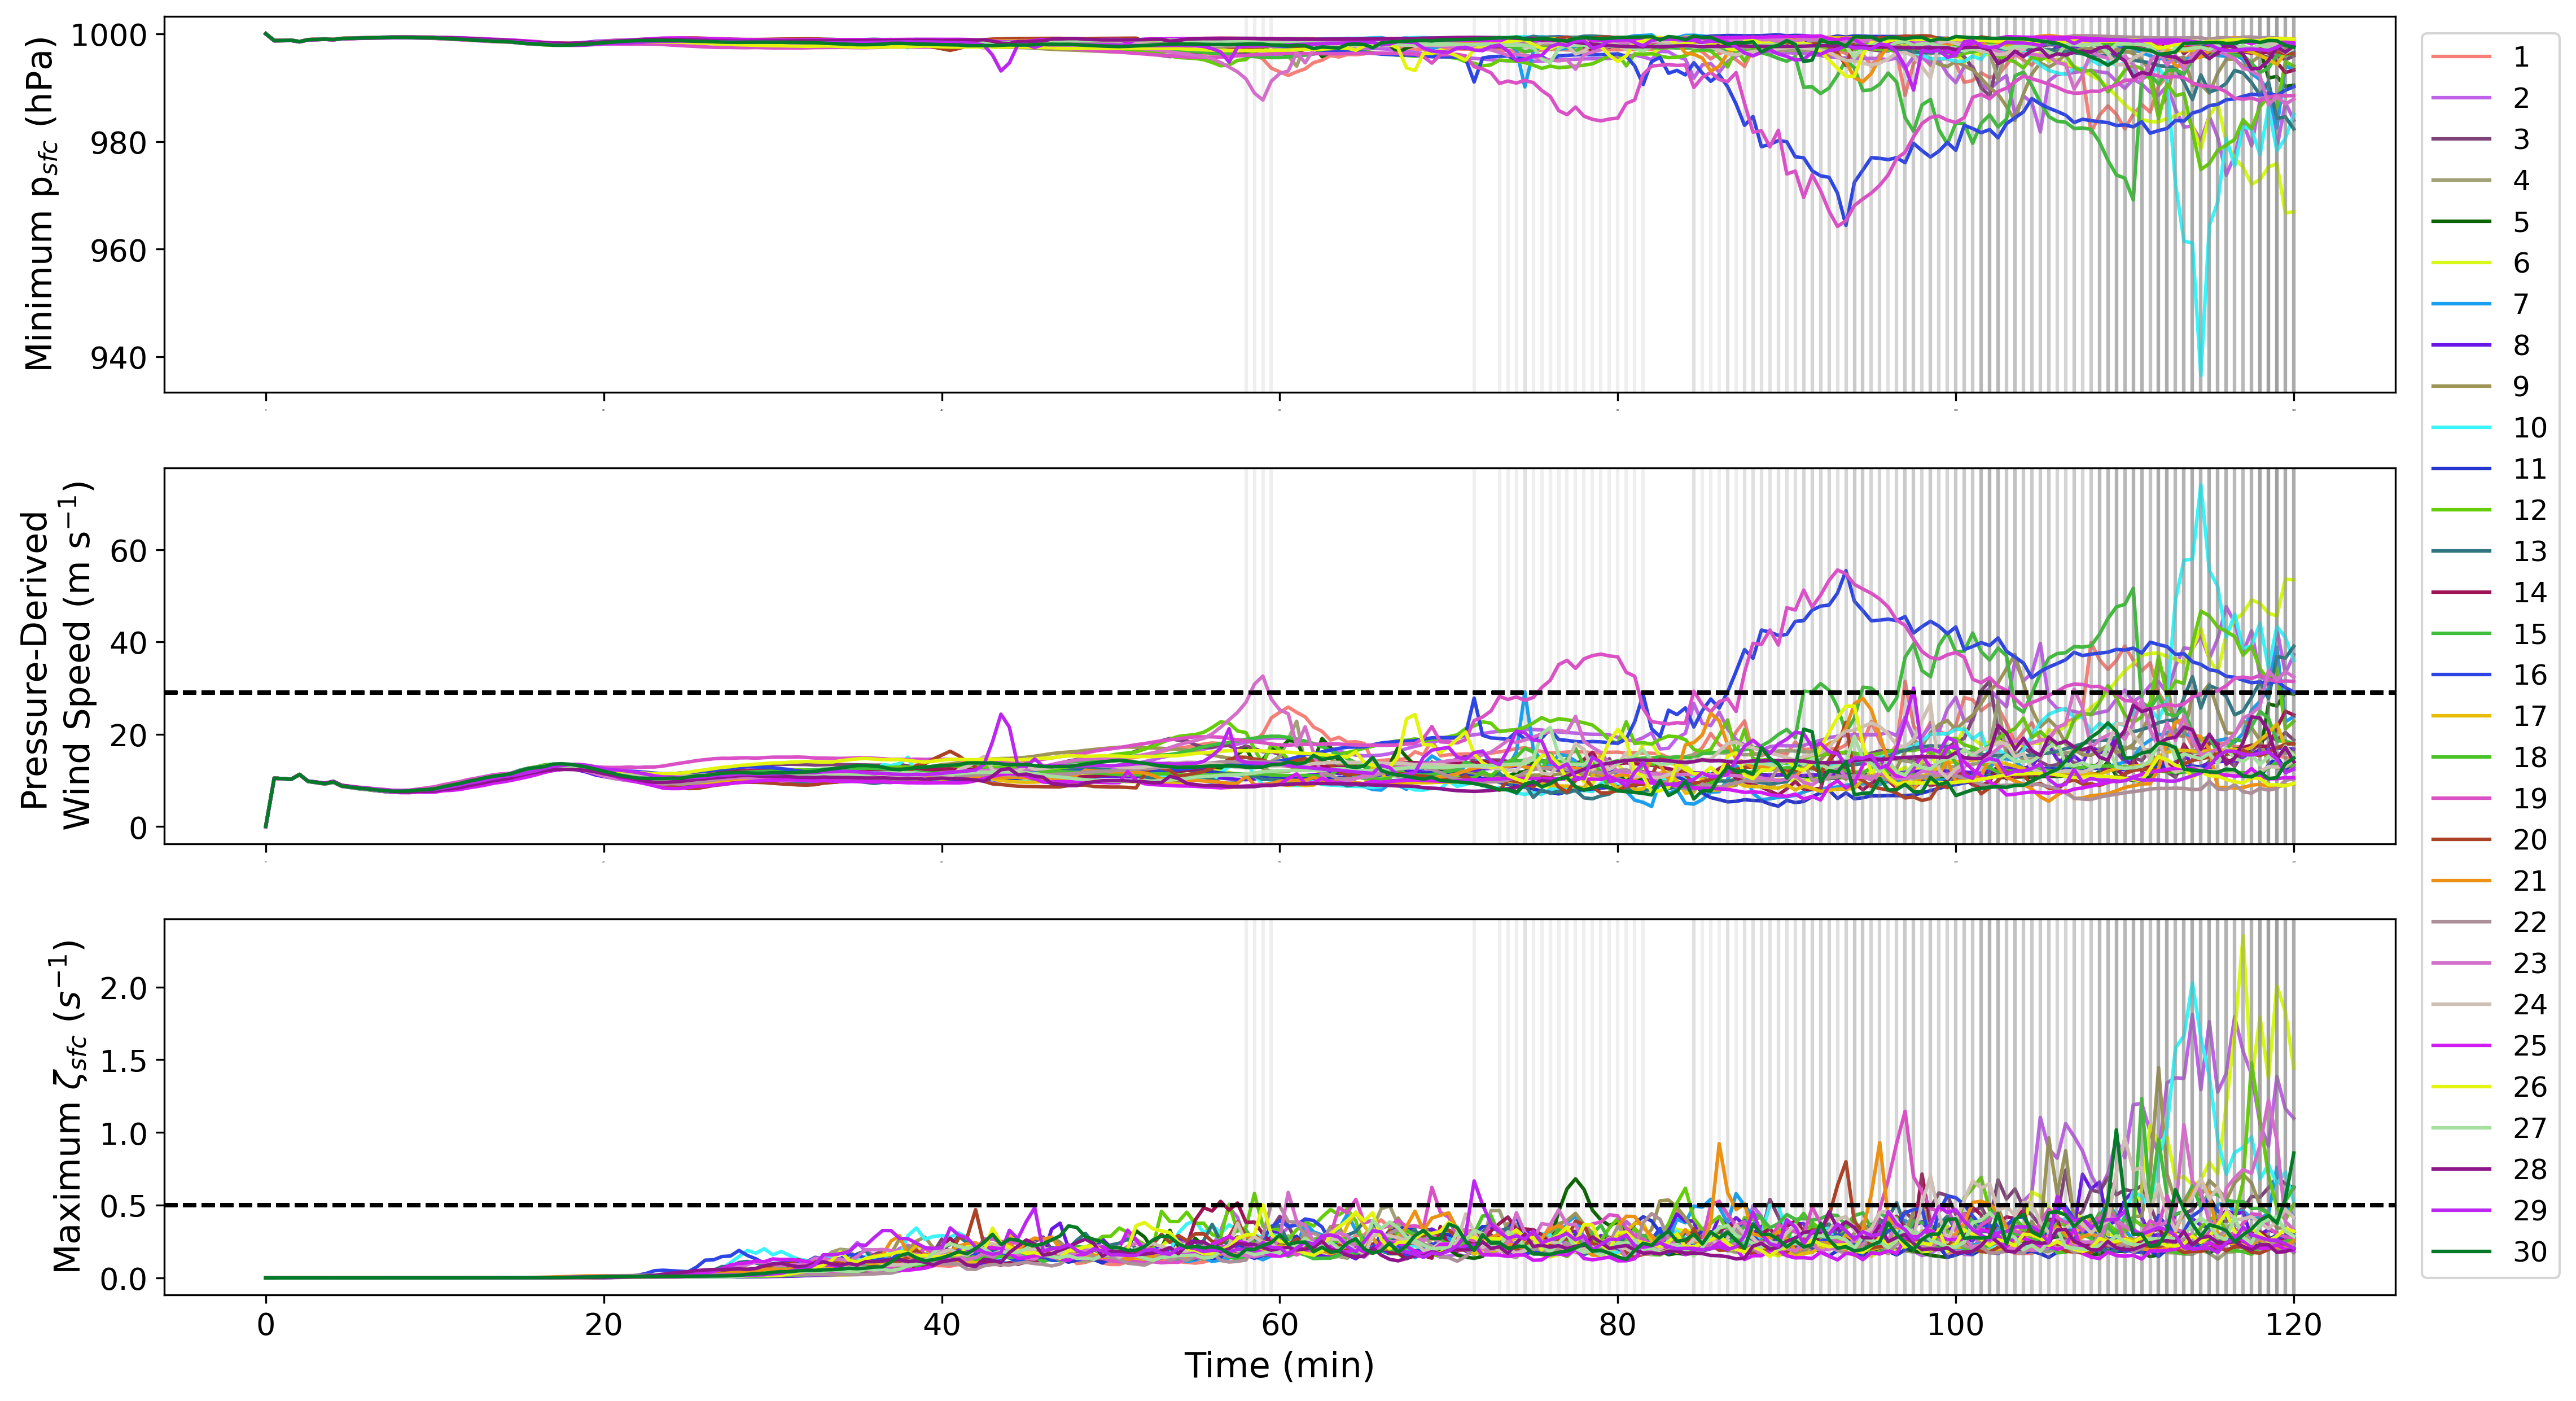

In [8]:
# Create Plot that shows the pressure driven max velocity

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 3, figsize=(17,10), dpi = 300)  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    #gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    vort = stats['vortsfc']
    min_press = stats['psfcmin']
    max_velo = comp_velo(sim_paths[x], min_press)
    
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(max_velo))):
        if (max_velo[t] >= 26):
            axs[0].axvline(x=time_ind[t], alpha = 0.12, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.12, color = 'grey')
            axs[2].axvline(x=time_ind[t], alpha = 0.12, color = 'grey')

    
    # Top Plot: Min Surface Pressure
    axs[0].plot(time_ind, min_press/100, color = color, label = f'{x+1}')
    
    axs[0].set_ylabel('Minimum p$_{sfc}$ (hPa)', fontsize = 15)
    axs[0].tick_params(axis='y', labelsize=13)
    axs[0].tick_params(axis='x', labelsize=0)
    
     # Middle Plot: Max wind speed derived from minimum surface pressure
    axs[1].plot(time_ind, max_velo, color = color, label = f'{x+1}')
    #axs[0].legend()
    axs[1].set_ylabel('Pressure-Derived\nWind Speed (m s$^{-1}$)', fontsize = 15)
    # plot axhline for tornadic threshold
    axs[1].axhline(y=29, linestyle='--', color = 'k')
    axs[1].legend(loc='center right', fontsize = 12,  bbox_to_anchor=(.78, 0, 0.3, 1))
    axs[1].tick_params(axis='y', labelsize=13)
    axs[1].tick_params(axis='x', labelsize=0)
    
    # Bottom Plot: Vertical Vorticity exceeding .25 m/s
    axs[2].plot(time_ind, vort, color = color, label = f'{x+1}')
    #axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[2].set_ylabel('Maximum $\zeta_{sfc}$ ($s^{-1}$)', fontsize = 15)
    # plot axhline for tornadic threshold
    axs[2].axhline(y = 0.5, linestyle='--', color = 'k')
    axs[2].set_xlabel('Time (min)', fontsize = 15)
    axs[2].tick_params(axis='y', labelsize=13)
    axs[2].tick_params(axis='x', labelsize=13)
    
    
    
    # Title the Figure
    # plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


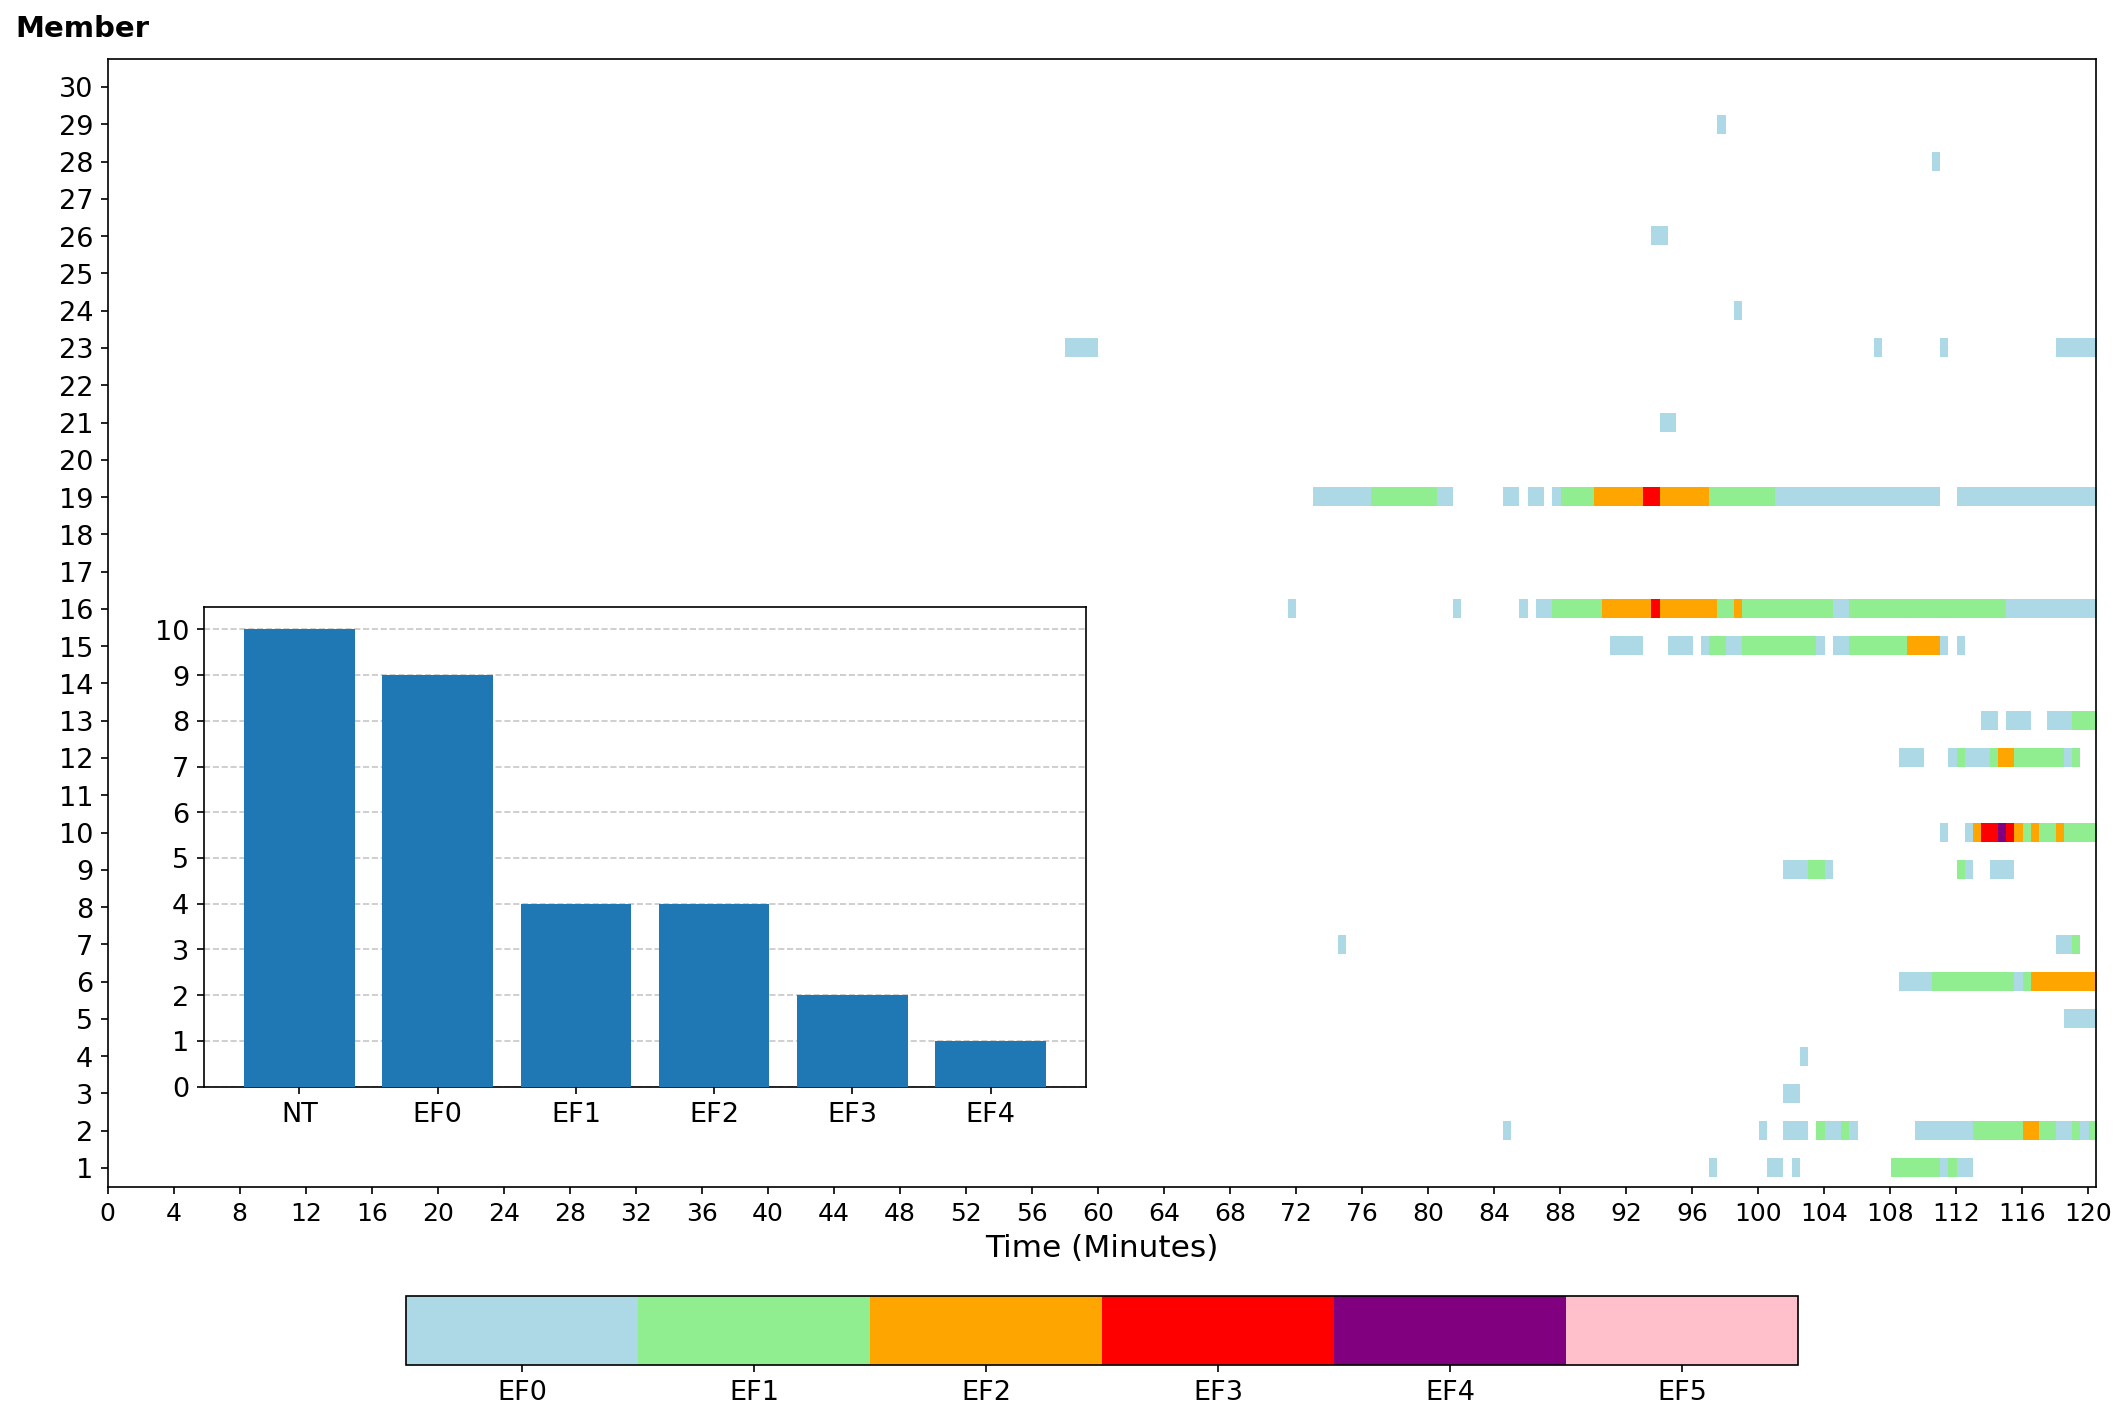

In [16]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10), dpi = 150)

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.5  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(np.arange(1,31,1), fontsize = 13)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize = 12)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=15)
#ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.075,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"], fontsize = 13)


fig.text(-.01, 1, 'Member', weight = 'bold', fontsize = 14) 

# Add New Axes and Histogram
new_ax = fig.add_axes([0.08, 0.3, 0.42, 0.32])
new_ax.bar(unique, counts, tick_label=[custom_labels[u] for u in unique], zorder=3)
# Set integer y-ticks
new_ax.set_yticks(range(0, max(counts) + 1))
new_ax.tick_params(axis='y', labelsize=13)
new_ax.tick_params(axis='x', labelsize=13)
# Add gridlines
new_ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# plt.tight_layout()
# plt.show()


plt.tight_layout()
plt.show()




# Plots for Presentation

100%|██████████| 241/241 [00:00<00:00, 2870.50it/s]


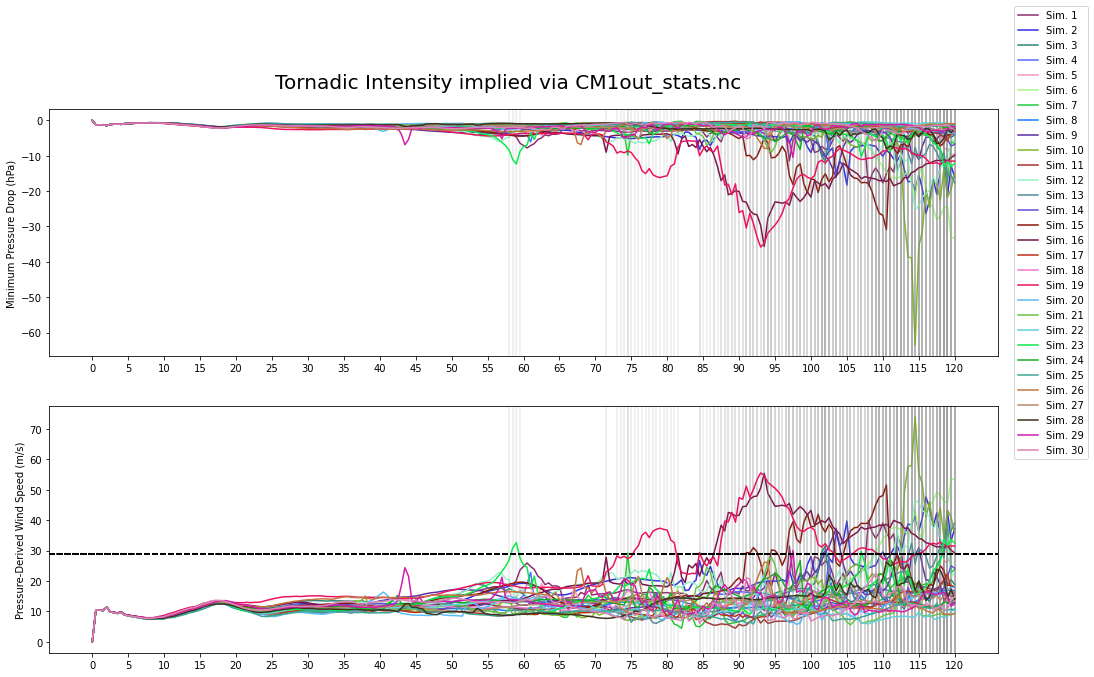

In [6]:
# Create Plot that shows the pressure driven max velocity

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize=(17,10))  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    #gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    #vort = stats['vortsfc']
    min_press = stats['psfcmin']
    max_velo = comp_velo(sim_paths[x], min_press)
    # read in first 3 pressure levels
    press = xr.open_dataset(sim_paths[x] + '/' 
                                + sim_names[0])['prs'].isel(time=0, zh = slice(0,3), yh = 0, xh = 0).values
    # constants of taylor approximation/expansion
    c1 = 1.875
    c2 = -1.25
    c3 = 0.375
    
    # compute mean surface pressure
    mean_press = c1*press[0] + c2*press[1] + c3*press[2]
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(max_velo))):
        if (max_velo[t] >= 26):
            axs[0].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            
    # Top Plot: Vertical Vorticity exceeding .5 m/s
    #axs[0].plot(time_ind, vort, color = color, label = f'Sim. {x+1}')
    #axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    #axs[0].set_ylabel('Maximum Surface Vert. Vorticity ($s^{-1}$)')
    # plot axhline for tornadic threshold
    #axs[0].axhline(y = 0.5, linestyle='--', color = 'k')
    #axs[0].set_xticks(np.arange(0,121,5))
    #axs[0].set_ylim(0,0.6)
    
    # Top Plot: Min Surface Pressure
    axs[0].plot(time_ind, (min_press- mean_press)/100, color = color, label = f'Sim. {x+1}')
    axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[0].set_ylabel('Minimum Pressure Drop (hPa)')
    axs[0].set_xticks(np.arange(0,121,5))
    #axs[0].set_ylim(-10)
    
     # Bottom Plot: Max wind speed derived from minimum surface pressure
    axs[1].plot(time_ind, max_velo, color = color, label = f'Sim. {x+1}')
    #axs[0].legend()
    axs[1].set_ylabel('Pressure-Derived Wind Speed (m/s)')
    # plot axhline for tornadic threshold
    axs[1].axhline(y=29, linestyle='--', color = 'k')
    axs[1].set_xticks(np.arange(0,121,5))
    
    # Title the Figure
    plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)

100%|██████████| 241/241 [00:00<00:00, 2940.09it/s]


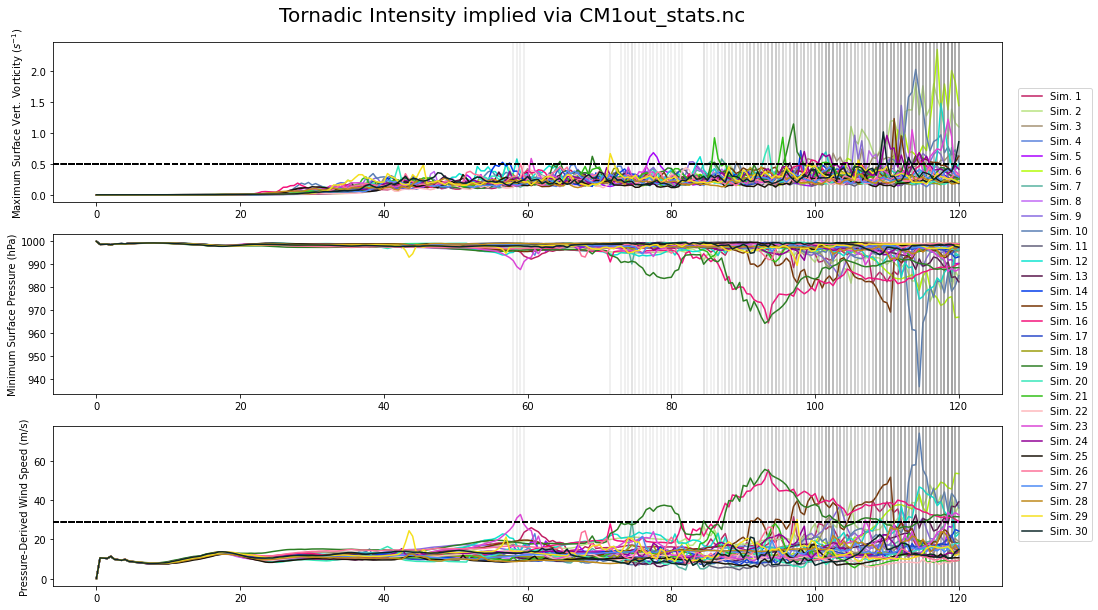

In [7]:
# Create Plot that shows the pressure driven max velocity

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 3, figsize=(17,10))  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    #gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    vort = stats['vortsfc']
    min_press = stats['psfcmin']
    max_velo = comp_velo(sim_paths[x], min_press)
    
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(max_velo))):
        if (max_velo[t] >= 26):
            axs[0].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')
            axs[2].axvline(x=time_ind[t], alpha = 0.15, color = 'grey')

    # Top Plot: Vertical Vorticity exceeding .25 m/s
    axs[0].plot(time_ind, vort, color = color, label = f'Sim. {x+1}')
    #axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[0].set_ylabel('Maximum Surface Vert. Vorticity ($s^{-1}$)')
    # plot axhline for tornadic threshold
    axs[0].axhline(y = 0.5, linestyle='--', color = 'k')
    
    # Middles Plot: Min Surface Pressure
    axs[1].plot(time_ind, min_press/100, color = color, label = f'Sim. {x+1}')
    axs[1].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[1].set_ylabel('Minimum Surface Pressure (hPa)')
    
     # Bottom Plot: Max wind speed derived from minimum surface pressure
    axs[2].plot(time_ind, max_velo, color = color, label = f'Sim. {x+1}')
    #axs[0].legend()
    axs[2].set_ylabel('Pressure-Derived Wind Speed (m/s)')
    # plot axhline for tornadic threshold
    axs[2].axhline(y=29, linestyle='--', color = 'k')
    
    
    # Title the Figure
    plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)

In [11]:
# Create a cell that stores the ground relative wind for each simulation based on the cm1out_stats file

TLV_tracker = {}

for sim in tqdm(range(len(sim_paths))):
    # Read in Stats File For Each Simulation
    stats = xr.open_dataset(sim_paths[sim] + '/cm1out_stats.nc')
    
    # Compute Max GR_wind and Read in Max Vert Vorticity
    min_press = stats['psfcmin']
    #vort = stats['vortsfc'] 
    max_wind = comp_velo(sim_paths[sim], min_press)
    
    # Find Points where gr_wind > 29 and vort > 0.25 and save them (gr_wind, zvort)
    tracks = np.zeros((len(stats['time']), 2))
    for x in range(tracks.shape[0]):
        if (max_wind[x] >= 26):
            tracks[x] = [max_wind[x], vort[x]]
    # Save the Tracks for Each Simulation
    TLV_tracker[run_names[sim]] = tracks
    
    

100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


In [12]:
# Apply Ratings to TLV Tracker

# Rough Enhanced Fujita Scale Wind 
EF0_low = 26 #29
EF0_high = 34 #38 
EF1_low = 34 #38
EF1_high = 44 #49
EF2_low = 44 #49
EF2_high = 54 #60
EF3_low = 54 #60
EF3_high = 65# 73
EF4_low = 65# 73
EF4_high = 80 #89
EF5 = 80 #89

# Apply Ratings
TLV_ratings = {}
for sim in tqdm(range(len(run_names))):
    # Empty Array for Ratings
    ratings = np.empty((len(TLV_tracker[run_names[sim]])), dtype='<U10')
    # Determine Rating
    for t in range(len(ratings)):
        gr_wind = TLV_tracker[run_names[sim]][t, 0]
        
         # EF0 Criteria
        if (gr_wind > EF0_low) & (gr_wind < EF0_high):
            ratings[t] = 'EF0'
            
        # EF1 Criteria
        if (gr_wind > EF1_low) & (gr_wind < EF1_high):
            ratings[t] = 'EF1'
            
        # EF2 Criteria
        if (gr_wind > EF2_low) & (gr_wind < EF2_high):
            ratings[t] = 'EF2'
            
        # EF3 Criteria
        if (gr_wind > EF3_low) & (gr_wind < EF3_high):
            ratings[t] = 'EF3'
            
        # EF4 Criteria
        if (gr_wind > EF4_low) & (gr_wind < EF4_high):
            ratings[t] = 'EF4'
            
        # EF5 Criteria 
        if (gr_wind > EF5):
            ratings[t] = 'EF5'
        
        # No Tornado
        if (gr_wind == np.nan):
            ratings[t] = 'None'
    # Save Ratings
    TLV_ratings[run_names[sim]] = ratings
    

100%|██████████| 30/30 [00:00<00:00, 1107.59it/s]


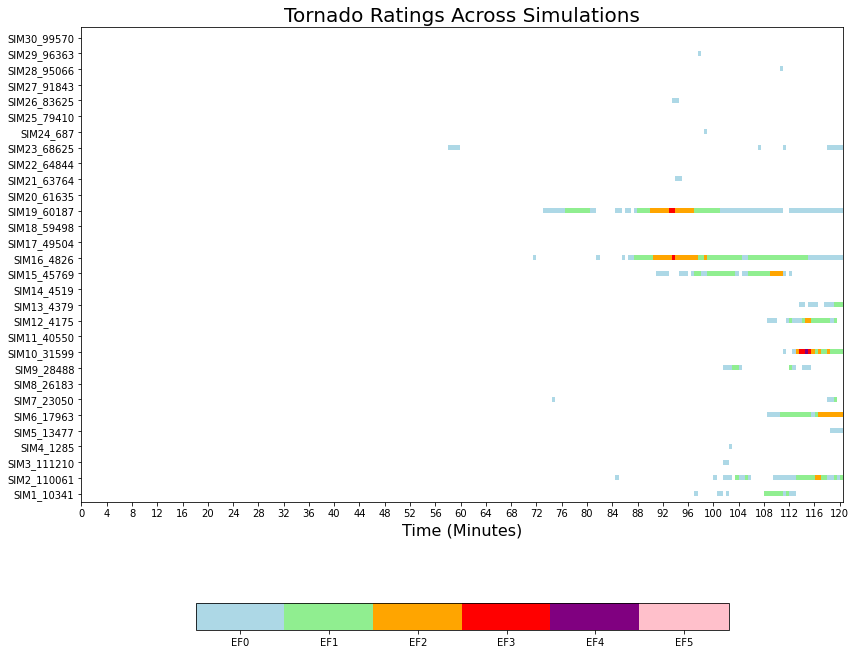

In [12]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(simulation_names)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=16)
ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()
plt.show()




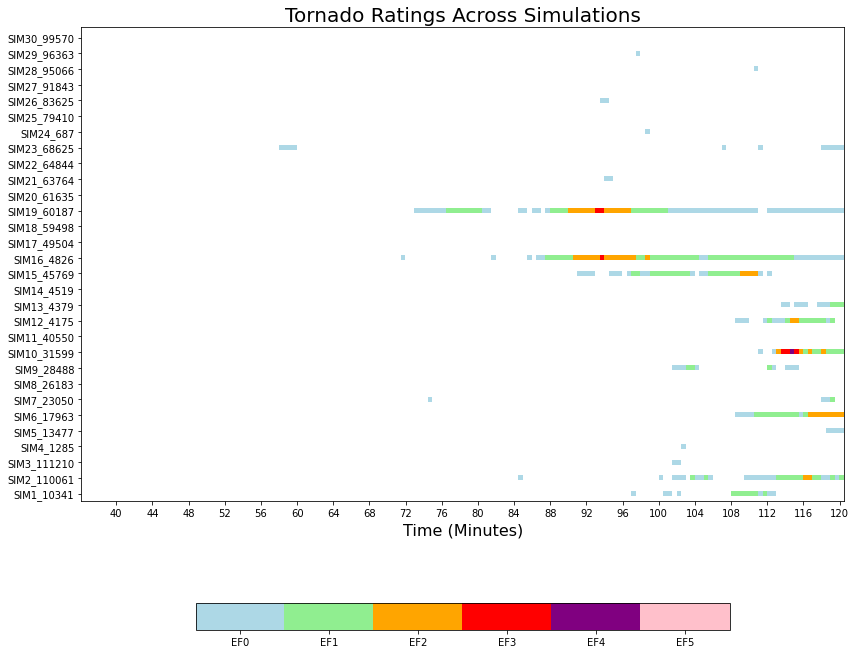

In [13]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(simulation_names)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
x_min, x_max = ax.get_xlim()  # Get the horizontal extent
ax.set_xlim((x_max-x_min)*.3)
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=16)
ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()
plt.show()




100%|██████████| 30/30 [00:00<00:00, 1628.43it/s]


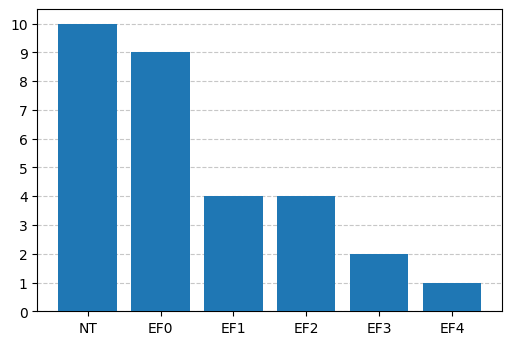

In [14]:
# Create a histogram of highest rating acquired by each simulation
hist_rating = np.zeros((len(run_names)), dtype=int)

# First figure out the highest rating achieved by each simulation and save it
for sim in tqdm(range(len(run_names))):
    # Read in the list of ratings for each simulation
    ratings = TLV_ratings[run_names[sim]]
    rate = np.zeros((len(ratings)), dtype = int)
    # iterate over each rating per simulation and save the highest rating only
    for x in range(len(ratings)):
        # check for each individual rating
        if ratings[x] == '':
            rate[x] = 0
        if ratings[x] == 'EF0':
            rate[x] = 1
        if ratings[x] == 'EF1':
            rate[x] = 2
        if ratings[x] == 'EF2':
            rate[x] = 3
        if ratings[x] == 'EF3':
            rate[x] = 4
        if ratings[x] == 'EF4':
            rate[x] = 5
        if ratings[x] == 'EF5':
            rate[x] = 6 
    # Save highest rating for each simulation
    hist_rating[sim] = rate.max()

# Create the histogram

# first define labels
custom_labels = {0: 'NT',
                 1: 'EF0',
                 2: 'EF1',
                 3: 'EF2',
                 4: 'EF3',
                 5: 'EF4',
                 6: 'EF5'}
# Count Occurences
unique, counts = np.unique(hist_rating, return_counts=True)

# Plot
plt.figure(figsize=(6, 4), dpi=100)
hist = plt.bar(unique, counts, tick_label=[custom_labels[u] for u in unique], zorder=3)
# Set integer y-ticks
plt.yticks(range(0, max(counts) + 1))
# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

    
        
        

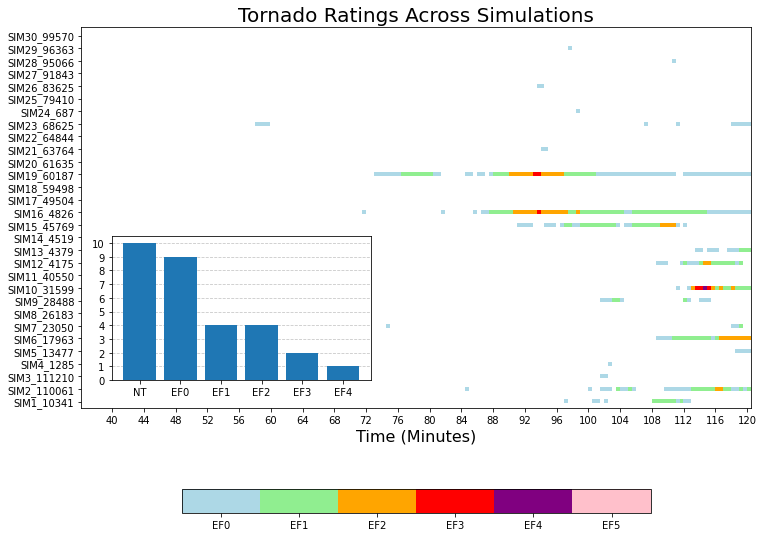

In [15]:
# Combine Ratings and Histogram
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(simulation_names)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
x_min, x_max = ax.get_xlim()  # Get the horizontal extent
ax.set_xlim((x_max-x_min)*.3)
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=16)
ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

# Add New Axes and Histogram
new_ax = fig.add_axes([0.16, 0.39, 0.3, 0.2])
new_ax.bar(unique, counts, tick_label=[custom_labels[u] for u in unique], zorder=3)
# Set integer y-ticks
new_ax.set_yticks(range(0, max(counts) + 1))
# Add gridlines
new_ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# plt.tight_layout()
# plt.show()




# Below is Tornadic Intensity/Ratings based on CM1out_stats files: Vorticity and Ground-Relative Wind being joint criteria.

### Inaccurate because ground-relative winds are excessively large and present in the outflow boundary due to free-slip boundary conditions not reducing wind speeds in the lowest model level.

100%|██████████| 241/241 [00:00<00:00, 687.74it/s]


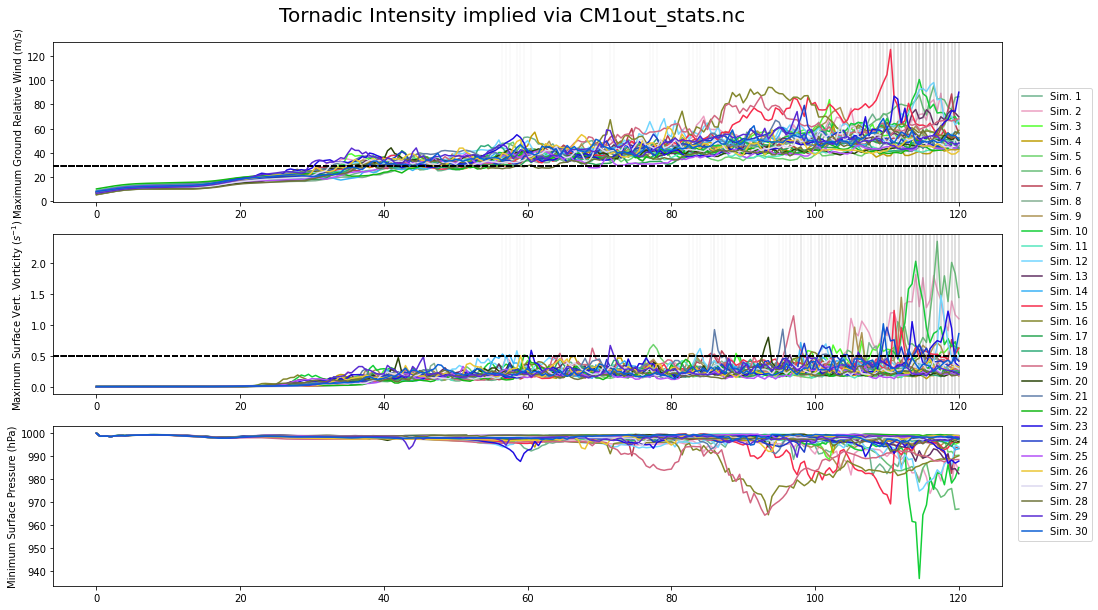

In [10]:
# Alternate Tornado Tracking Algorithm (The issue with this 
# method is that we don't know where in the model domain these points are, or if they colocated) 

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 3, figsize=(17,10))  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    vort = stats['vortsfc']
    min_press = stats['psfcmin']/100
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(gr_wind))):
        if (gr_wind[t] >= 29) & (vort[t] >= 0.5):
            axs[0].axvline(x=time_ind[t], alpha = 0.05, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.05, color = 'grey')

    # Top Plot: Ground Relative Wind exceeding 29 m/s 
    axs[0].plot(time_ind, gr_wind, color = color, label = f'Sim. {x+1}')
    #axs[0].legend()
    axs[0].set_ylabel('Maximum Ground Relative Wind (m/s)')
    # plot axhline for tornadic threshold
    axs[0].axhline(y=29, linestyle='--', color = 'k')
    
    # Middle Plot: Vertical Vorticity exceeding .25 m/s
    axs[1].plot(time_ind, vort, color = color, label = f'Sim. {x+1}')
    axs[1].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[1].set_ylabel('Maximum Surface Vert. Vorticity ($s^{-1}$)')
    # plot axhline for tornadic threshold
    axs[1].axhline(y = 0.5, linestyle='--', color = 'k')
    
    # Bottom Plot: Min Surface Pressure
    axs[2].plot(time_ind, min_press, color = color, label = f'Sim. {x+1}')
    #axs[2].legend()
    axs[2].set_ylabel('Minimum Surface Pressure (hPa)')
    
    
    # Title the Figure
    plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)
    
    
    

100%|██████████| 241/241 [00:00<00:00, 1040.89it/s]


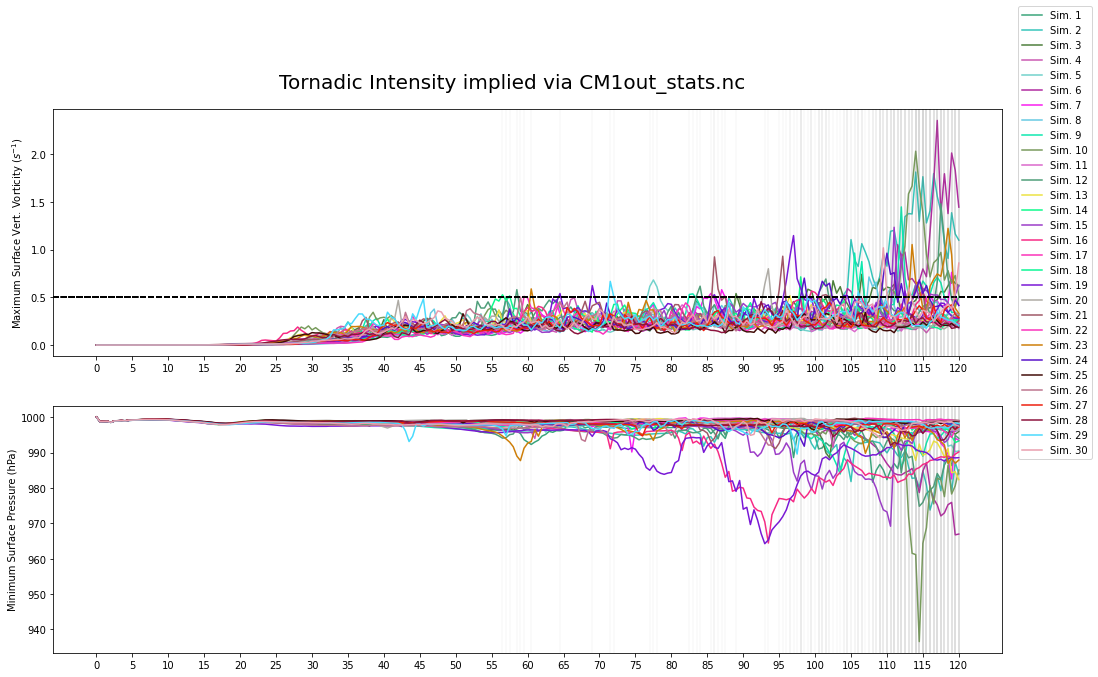

In [14]:
# Alternate Tornado Tracking Algorithm (The issue with this 
# method is that we don't know where in the model domain these points are, or if they colocated) 

# Create A Loop that iteratively plots
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize=(17,10))  # plot initialization
time_ind = np.linspace(0,120, 241) # time index: in units of minutes 
# Chooses random color for each simulation
def rand_color():
    return [random.random(), random.random(), random.random()]
for x in range(len(sim_paths)):
    # read in the cm1out stats for each simulation
    stats = xr.open_dataset(sim_paths[x] + '/' + 'cm1out_stats.nc')
    
    # random color for each simulation
    color = rand_color()
    
    # Read in Variables
    gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    vort = stats['vortsfc']
    min_press = stats['psfcmin']/100
    
    # Add Vertical Shading Whenever Tornadic Criteria for GR wind and Vert Vorticity is met
    for t in tqdm(range(len(gr_wind))):
        if (vort[t] >= 0.5):
            axs[0].axvline(x=time_ind[t], alpha = 0.05, color = 'grey')
            axs[1].axvline(x=time_ind[t], alpha = 0.05, color = 'grey')

    # Top Plot: Ground Relative Wind exceeding 29 m/s 
    #axs[0].plot(time_ind, gr_wind, color = color, label = f'Sim. {x+1}')
    #axs[0].legend()
    #axs[0].set_ylabel('Maximum Ground Relative Wind (m/s)')
    # plot axhline for tornadic threshold
    #axs[0].axhline(y=29, linestyle='--', color = 'k')
    
    # Middle Plot: Vertical Vorticity exceeding .25 m/s
    axs[0].plot(time_ind, vort, color = color, label = f'Sim. {x+1}')
    axs[0].legend(loc='center right',  bbox_to_anchor=(.8, 0, 0.3, 1))
    axs[0].set_ylabel('Maximum Surface Vert. Vorticity ($s^{-1}$)')
    # plot axhline for tornadic threshold
    axs[0].axhline(y = 0.5, linestyle='--', color = 'k')
    axs[0].set_xticks(np.arange(0,121,5))
    
    # Bottom Plot: Min Surface Pressure
    axs[1].plot(time_ind, min_press, color = color, label = f'Sim. {x+1}')
    #axs[2].legend()
    axs[1].set_ylabel('Minimum Surface Pressure (hPa)')
    axs[1].set_xticks(np.arange(0,121,5))
    
    # Title the Figure
    plt.suptitle('Tornadic Intensity implied via CM1out_stats.nc', y = 0.93, fontsize=20)
    
    
    

In [18]:
# Create a cell that stores the ground relative wind for each simulation based on the cm1out_stats file

TLV_tracker = {}

for sim in tqdm(range(len(sim_paths))):
    # Read in Stats File For Each Simulation
    stats = xr.open_dataset(sim_paths[sim] + '/cm1out_stats.nc')
    
    # Compute Max GR_wind and Read in Max Vert Vorticity
    gr_wind = ((stats['svmax'].values+12.2)**2+(stats['sumax'].values+12.5)**2)**.5 # gr_wind calculation
    vort = stats['vortsfc'] 
    
    # Find Points where gr_wind > 29 and vort > 0.25 and save them (gr_wind, zvort)
    tracks = np.zeros((len(stats['time']), 2))
    for x in range(tracks.shape[0]):
        if (gr_wind[x] >= 29) & (vort[x] >= 0.5):
            tracks[x] = [gr_wind[x], vort[x]]
    # Save the Tracks for Each Simulation
    TLV_tracker[run_names[sim]] = tracks
    
    

100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


In [19]:
# Apply Ratings to TLV Tracker

# Rough Enhanced Fujita Scale Wind 
EF0_low = 29
EF0_high = 38 
EF1_low = 38
EF1_high = 49
EF2_low = 49
EF2_high = 60
EF3_low = 60
EF3_high = 73
EF4_low = 73
EF4_high = 89
EF5 = 89

# Apply Ratings
TLV_ratings = {}
for sim in tqdm(range(len(run_names))):
    # Empty Array for Ratings
    ratings = np.empty((len(TLV_tracker[run_names[sim]])), dtype='<U10')
    # Determine Rating
    for t in range(len(ratings)):
        gr_wind = TLV_tracker[run_names[sim]][t, 0]
        
         # EF0 Criteria
        if (gr_wind > EF0_low) & (gr_wind < EF0_high):
            ratings[t] = 'EF0'
            
        # EF1 Criteria
        if (gr_wind > EF1_low) & (gr_wind < EF1_high):
            ratings[t] = 'EF1'
            
        # EF2 Criteria
        if (gr_wind > EF2_low) & (gr_wind < EF2_high):
            ratings[t] = 'EF2'
            
        # EF3 Criteria
        if (gr_wind > EF3_low) & (gr_wind < EF3_high):
            ratings[t] = 'EF3'
            
        # EF4 Criteria
        if (gr_wind > EF4_low) & (gr_wind < EF4_high):
            ratings[t] = 'EF4'
            
        # EF5 Criteria 
        if (gr_wind > EF5):
            ratings[t] = 'EF5'
        
        # No Tornado
        if (gr_wind == np.nan):
            ratings[t] = 'None'
    # Save Ratings
    TLV_ratings[run_names[sim]] = ratings
    

100%|██████████| 30/30 [00:00<00:00, 1050.91it/s]


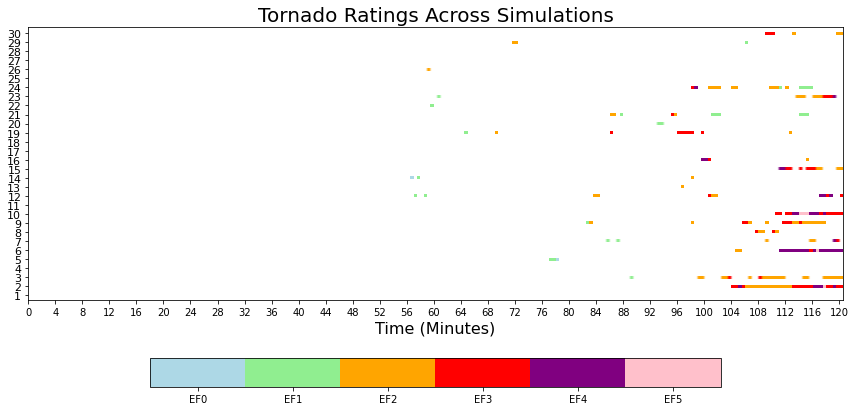

In [21]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(np.arange(1,31,1), fontsize = 11)
#ax.set_yticklabels(simulation_names)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=16)
ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()
plt.show()

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


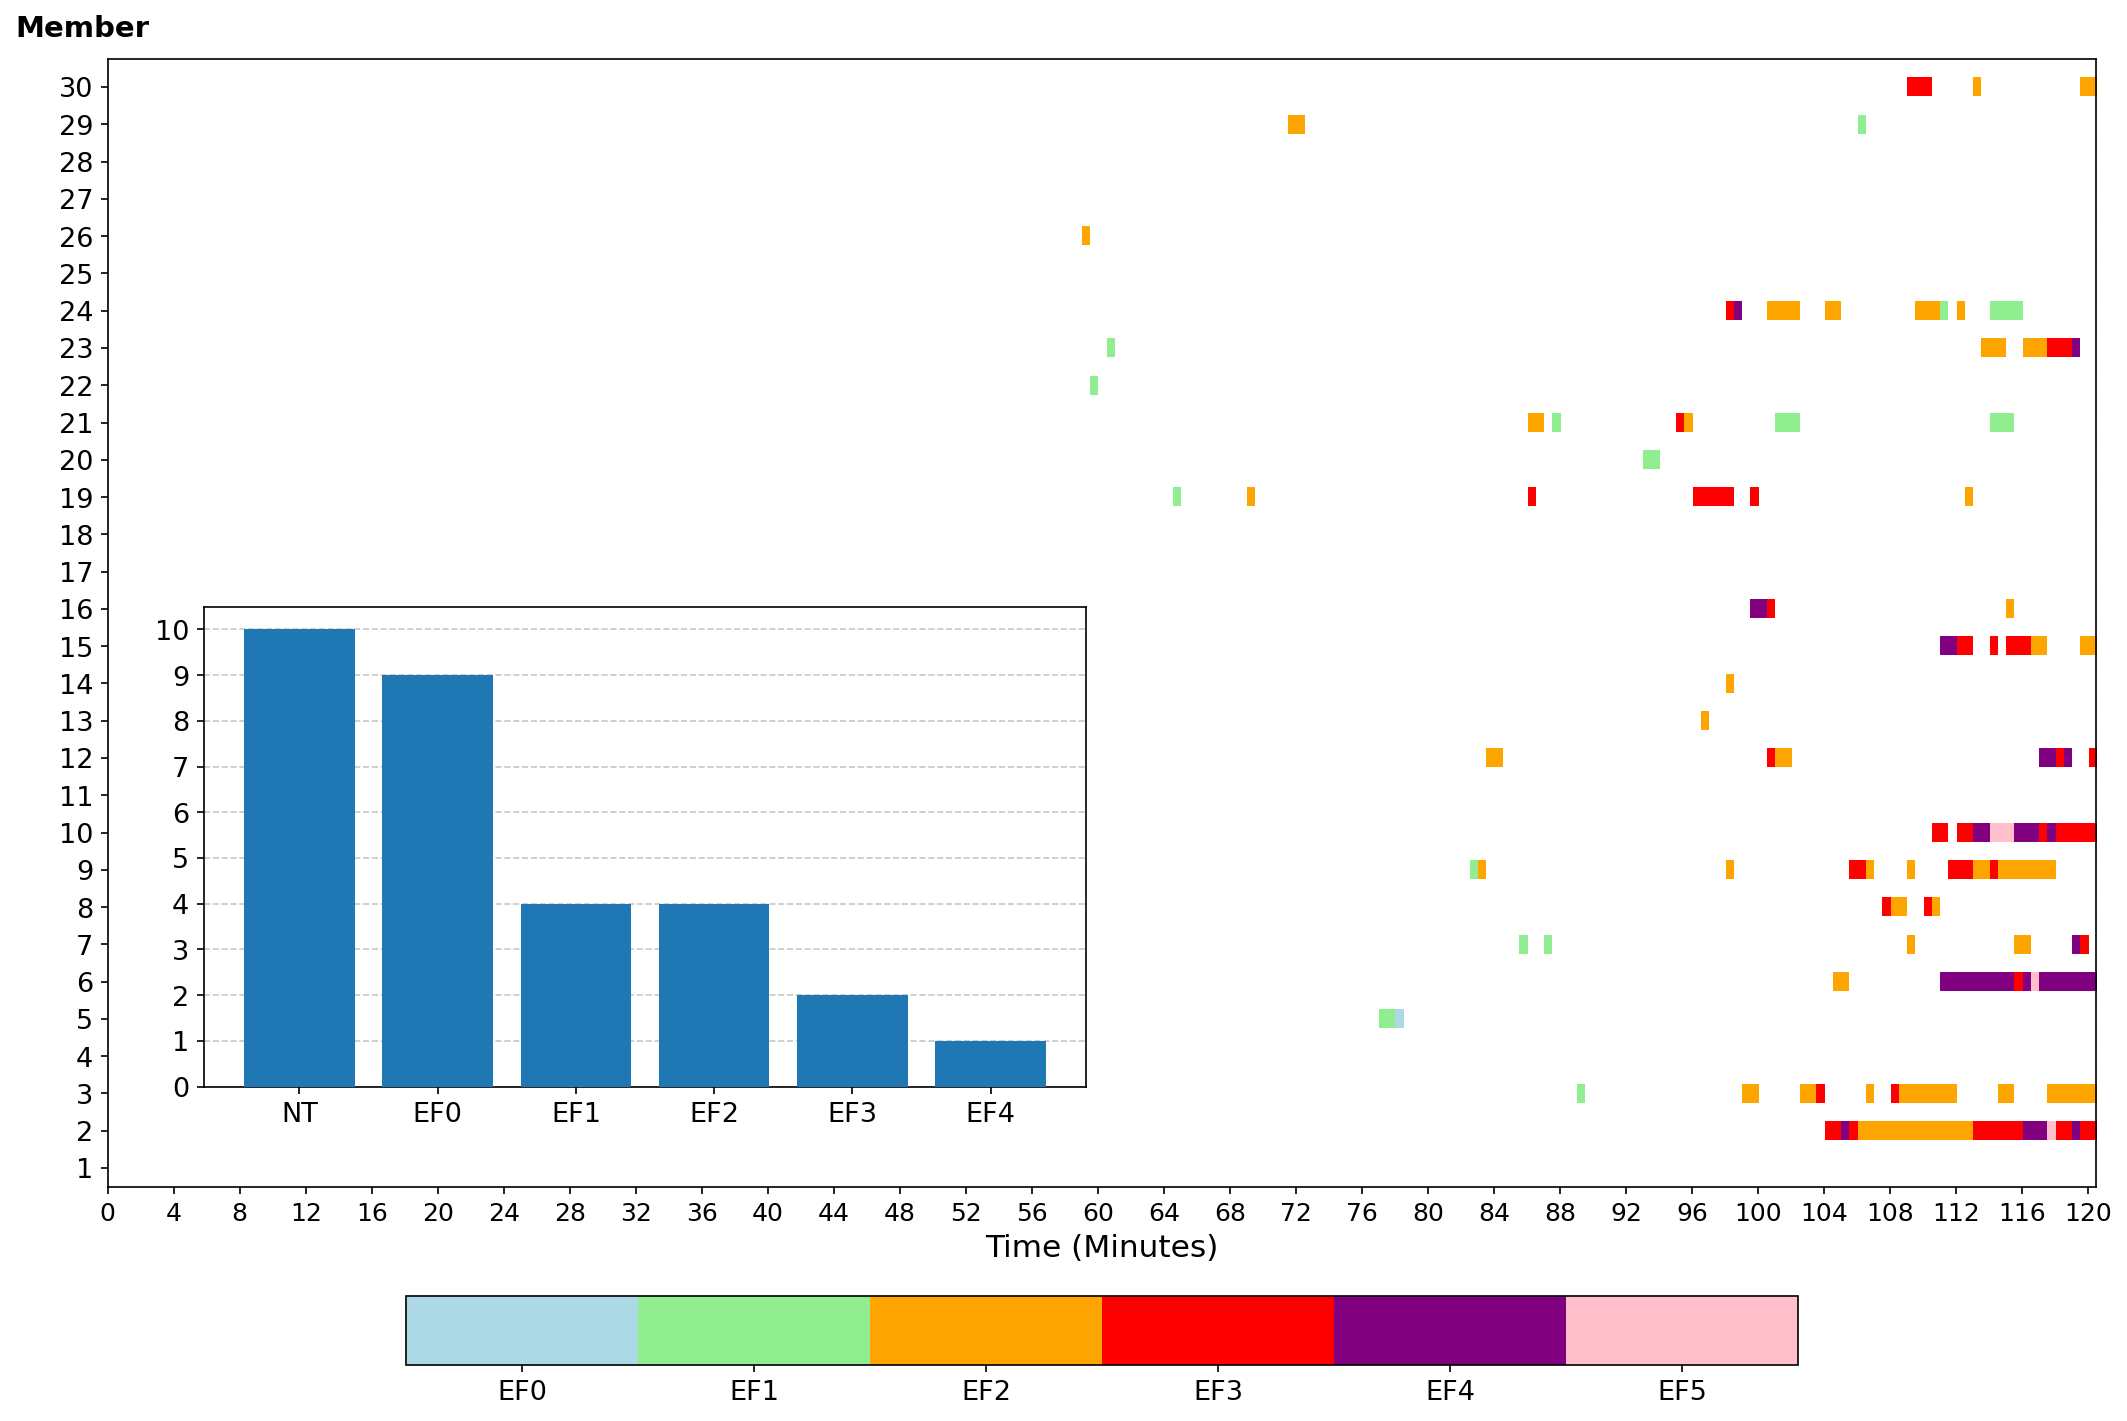

In [22]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10), dpi = 150)

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.5  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax.imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-axis
ax.set_yticks(np.arange(num_simulations) + vertical_gap)
ax.set_yticklabels(np.arange(1,31,1), fontsize = 13)

# Customize the x-axis with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=31)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*4) for i in range(len(xtick_positions))]  # Generate labels from 0 to 249 at 5-min intervals
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize = 12)
y_min, y_max = ax.get_ylim()  # Get the vertical extent
ax.set_ylim(y_min-0.5, y_max+0.5)

# Customize the x-axis label and title
ax.set_xlabel("Time (Minutes)", fontsize=15)
#ax.set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    pad=0.075,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"], fontsize = 13)


fig.text(-.01, 1, 'Member', weight = 'bold', fontsize = 14) 

# Add New Axes and Histogram
new_ax = fig.add_axes([0.08, 0.3, 0.42, 0.32])
new_ax.bar(unique, counts, tick_label=[custom_labels[u] for u in unique], zorder=3)
# Set integer y-ticks
new_ax.set_yticks(range(0, max(counts) + 1))
new_ax.tick_params(axis='y', labelsize=13)
new_ax.tick_params(axis='x', labelsize=13)
# Add gridlines
new_ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# plt.tight_layout()
# plt.show()


plt.tight_layout()
plt.show()




# Attempt to Create Tornado Tracks Via SVS

100%|██████████| 28/28 [00:05<00:00,  5.33it/s]


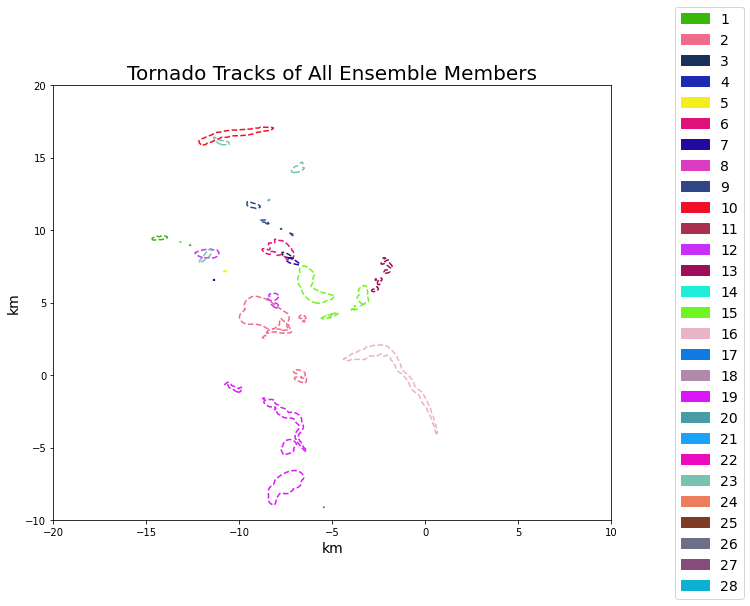

In [15]:
# Initialize Figure
fig = plt.figure(figsize=(10,8))

# Create a list to store legend handles
legend_handles = []

# Loop over each simulation and only choose vorticity values exceeding 0.25 s^-1
for sim in tqdm(range(len(sim_paths))):
    # Read in each svs file
    data = xr.open_dataset(sim_paths[sim] + '/' + sim_names[-1])['sps'][0]
    
    # Function to generate a random RGBA color
    def rand_color():
        return [random.random(), random.random(), random.random(), 1.0]  # Add Alpha=1.0 for full opacity
    
    # Random color for each simulation
    color = rand_color()
    
    # Isolate only the vorticity values that exceed 0.5 s^-1
    # Replace NaNs with 0 after filtering
    filtered_data = data.where(data < -700).fillna(0)
    
    # Plot Tornado Tracks
    plt.contour(x_data, y_data, data, levels=[-1000], colors=[color])
    
    # Add a legend handle for this simulation
    legend_handles.append(mpatches.Patch(color=color, label=f'{sim + 1}'))

# Add legend to the plot
plt.legend(handles=legend_handles, fontsize=14, loc='center right', bbox_to_anchor=(.95, 0, 0.3, 1))

# Set plot limits
plt.xlim(-20,10)
plt.ylim(-10, 20)
plt.title('Tornado Tracks of All Ensemble Members', fontsize=20)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)

# Display the plot
plt.show()


# Investigation

In [22]:
storm6_110 = xr.open_dataset(sim_paths[5]+ '/'+ sim_names[22])
storm10_110 = xr.open_dataset(sim_paths[9] + '/' + sim_names[22])
storm6_115 = xr.open_dataset(sim_paths[5]+ '/'+ sim_names[23])
storm10_115 = xr.open_dataset(sim_paths[9] + '/' + sim_names[23])
storm6_100 = xr.open_dataset(sim_paths[5]+ '/'+ sim_names[20])
storm10_100 = xr.open_dataset(sim_paths[9] + '/' + sim_names[20])


Text(0.5, 1.0, 'Storm 6 @ time: 110.0 min. Reflect. @ 0.9929999709129333 m')

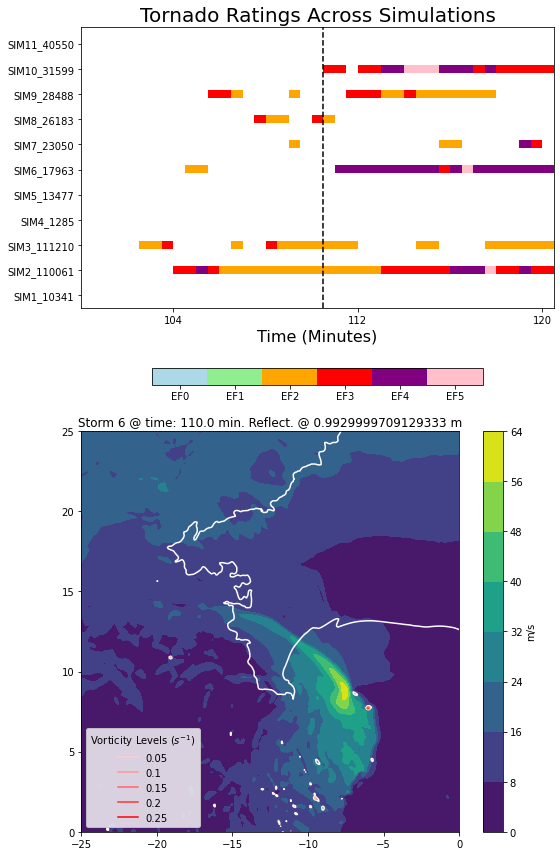

In [15]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=221, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(200)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For Storm6 at 110 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm6_110['time'][0].values/10**9)/60

u = storm6_110['uinterp'].isel(time=0, zh = 0)
v = storm6_110['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm6_110['xh'], storm6_110['yh'], gr_wind)
refl = ax[1].contour(storm6_110['xh'], storm6_110['yh'], storm6_110['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm6_110['xh'], storm6_110['yh'], storm6_110['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 6 @ time: {t} min. Reflect. @ {height} m')

Text(0.5, 1.0, 'Storm 10 @ time: 110.0 min. Reflect. @ 0.9929999709129333 m')

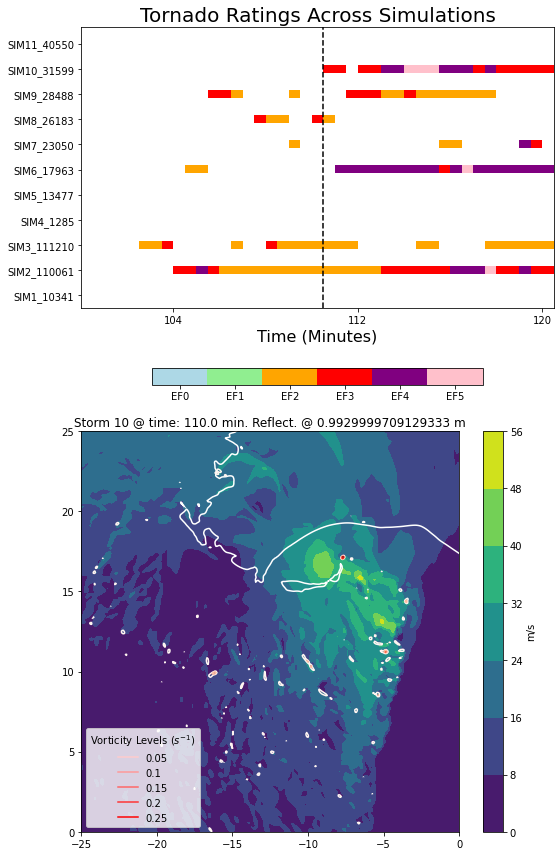

In [16]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=221, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(200)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For storm10 at 110 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm10_110['time'][0].values/10**9)/60

u = storm10_110['uinterp'].isel(time=0, zh = 0)
v = storm10_110['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm10_110['xh'], storm10_110['yh'], gr_wind)
refl = ax[1].contour(storm10_110['xh'], storm10_110['yh'], storm10_110['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm10_110['xh'], storm10_110['yh'], storm10_110['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 10 @ time: {t} min. Reflect. @ {height} m')

Text(0.5, 1.0, 'Storm 6 @ time: 115.0 min. Reflect. @ 0.9929999709129333 m')

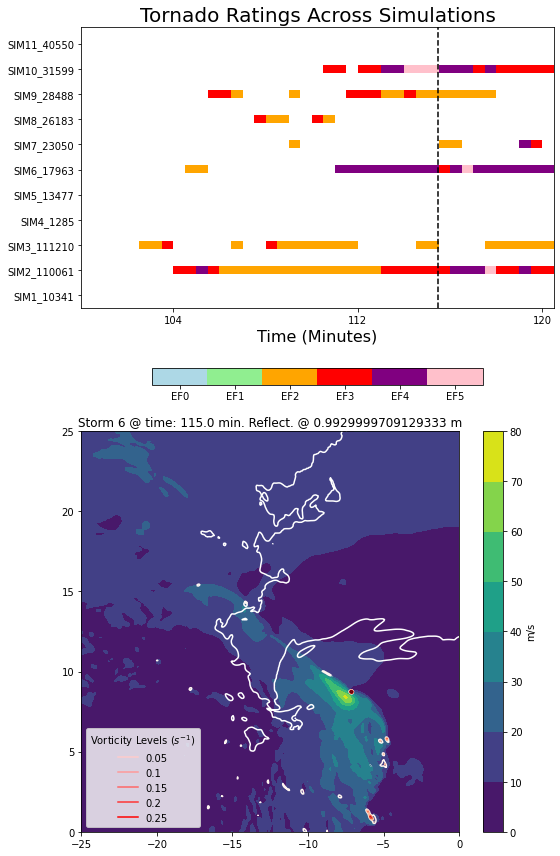

In [17]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=231, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(200)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For Storm6 at 115 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm6_115['time'][0].values/10**9)/60

u = storm6_115['uinterp'].isel(time=0, zh = 0)
v = storm6_115['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm6_115['xh'], storm6_115['yh'], gr_wind)
refl = ax[1].contour(storm6_115['xh'], storm6_115['yh'], storm6_115['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm6_115['xh'], storm6_115['yh'], storm6_115['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 6 @ time: {t} min. Reflect. @ {height} m')

Text(0.5, 1.0, 'Storm 10 @ time: 115.0 min. Reflect. @ 0.9929999709129333 m')

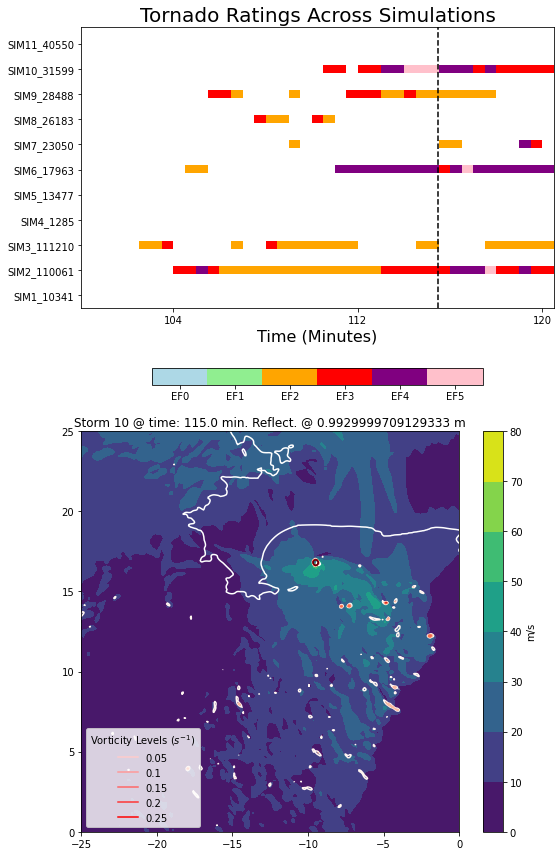

In [19]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=231, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(200)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For storm10 at 115 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm10_115['time'][0].values/10**9)/60

u = storm10_115['uinterp'].isel(time=0, zh = 0)
v = storm10_115['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm10_115['xh'], storm10_115['yh'], gr_wind)
refl = ax[1].contour(storm10_115['xh'], storm10_115['yh'], storm10_115['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm10_115['xh'], storm10_115['yh'], storm10_115['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 10 @ time: {t} min. Reflect. @ {height} m')

Text(0.5, 1.0, 'Storm 6 @ time: 100.0 min. Reflect. @ 0.9929999709129333 m')

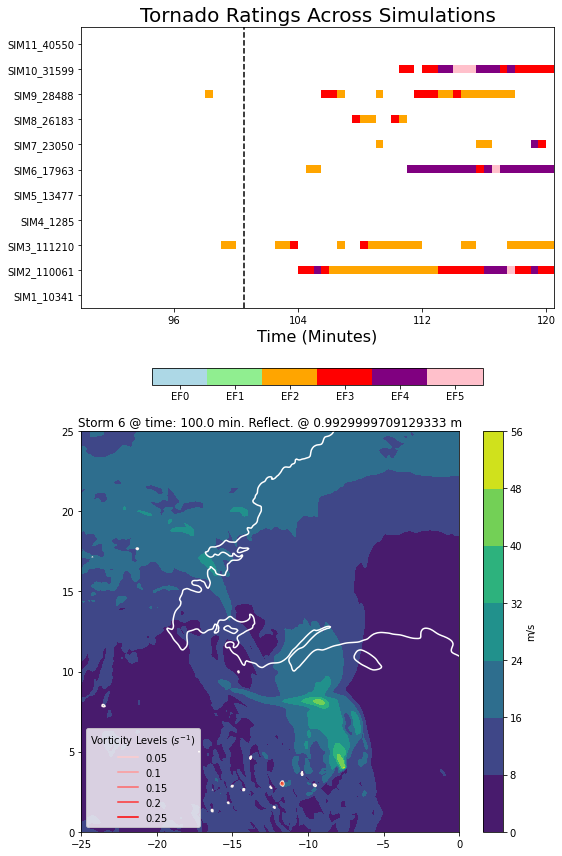

In [24]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=201, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(180)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For Storm6 at 100 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm6_100['time'][0].values/10**9)/60

u = storm6_100['uinterp'].isel(time=0, zh = 0)
v = storm6_100['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm6_100['xh'], storm6_100['yh'], gr_wind)
refl = ax[1].contour(storm6_100['xh'], storm6_100['yh'], storm6_100['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm6_100['xh'], storm6_100['yh'], storm6_100['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 6 @ time: {t} min. Reflect. @ {height} m')

Text(0.5, 1.0, 'Storm 10 @ time: 100.0 min. Reflect. @ 0.9929999709129333 m')

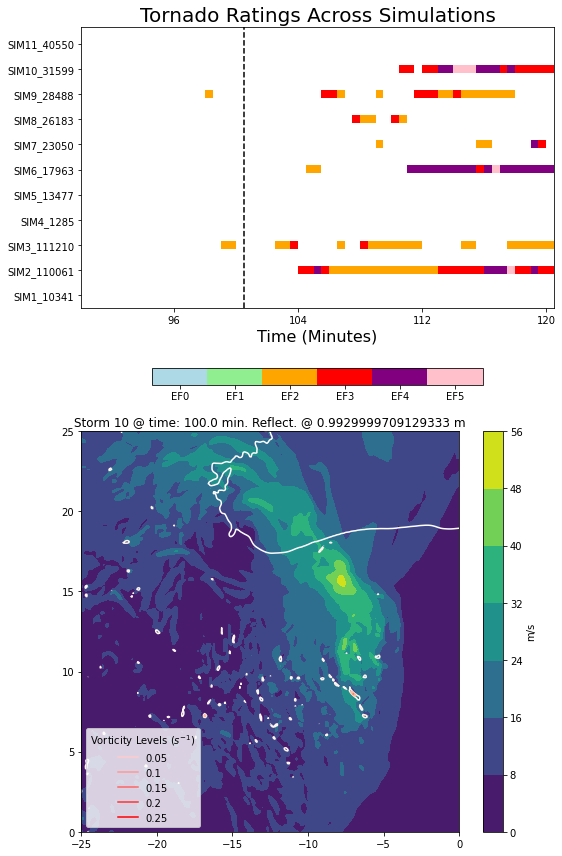

In [26]:
# Create A TLV Intensity Time Series for Each Simulation
# Map tornado ratings to colors
rating_to_color = {
    "": "white",  # Empty values as white
    "EF0": "lightblue",
    "EF1": "lightgreen",
    "EF2": "orange",
    "EF3": "red",
    "EF4": "purple",
    "EF5": "pink"
}

# Convert TLV_ratings to a numerical grid for plotting
simulation_names = list(TLV_ratings.keys())
num_simulations = len(simulation_names)
time_steps = len(next(iter(TLV_ratings.values())))  # Assume all simulations have the same length

# Create a grid of RGBA values for plotting
color_grid = np.full((num_simulations, time_steps, 4), np.nan)  # Initialize with NaNs (RGBA)

for i, (sim, values) in enumerate(TLV_ratings.items()):
    for j, rating in enumerate(values):
        color_grid[i, j] = mcolors.to_rgba(rating_to_color[rating])

# Create the plot
fig, ax = plt.subplots(nrows = 2, figsize=(8, 12))

# Adjust vertical gap
vertical_gap = 0 # Space before the first simulation line
line_thickness = 0.3  # Adjust thickness of horizontal lines

# Plot the horizontal lines for each simulation
for i in range(num_simulations):
    ax[0].imshow(
        [color_grid[i]],  # Single row for each simulation
        aspect='auto',
        extent=[0, time_steps, i + vertical_gap - line_thickness / 2, i + vertical_gap + line_thickness / 2]
    )

# Customize the y-ax[0]is
ax[0].set_yticks(np.arange(num_simulations) + vertical_gap)
ax[0].set_yticklabels(simulation_names)

# Customize the x-ax[0]is with 5-minute intervals from 40 to 120
xtick_positions = np.linspace(0, time_steps - 1, num=16)  # 241 intervals for 1-min steps from 0 to 240
xtick_labels = [str(i*8) for i in range(len(xtick_positions))]
ax[0].axvline(x=201, color='black', linestyle='--', linewidth=1.5, label='x=200')# Generate labels from 0 to 249 at 5-min intervals
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels)
y_min, y_max = ax[0].get_ylim()  # Get the vertical extent
ax[0].set_ylim(y_min-0.5, y_max+0.5)
ax[0].set_xlim(180)

# Customize the x-ax[0]is label and title
ax[0].set_xlabel("Time (Minutes)", fontsize=16)
ax[0].set_title("Tornado Ratings Across Simulations", fontsize=20)

# Create a custom colorbar
cmap = mcolors.ListedColormap([rating_to_color[key] for key in ["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]])
norm = mcolors.BoundaryNorm(np.arange(7), cmap.N)  # 6 levels + 1 boundary
cbar = plt.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    ax=ax[0],
    orientation="horizontal",
    pad=0.15,
    shrink=0.7,
    ticks=np.arange(6) + 0.5
)
cbar.ax.set_xticklabels(["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"])

plt.tight_layout()


# Create Figure For storm10 at 100 min

#fig = plt.figure(figsize=(8,8))
t = np.int(storm10_100['time'][0].values/10**9)/60

u = storm10_100['uinterp'].isel(time=0, zh = 0)
v = storm10_100['vinterp'].isel(time=0, zh = 0)

gr_wind = ((u+12.2)**2+ (v+12.5)**2)**0.5

gr = ax[1].contourf(storm10_100['xh'], storm10_100['yh'], gr_wind)
refl = ax[1].contour(storm10_100['xh'], storm10_100['yh'], storm10_100['dbz'].isel(time=0, zh = 25), levels = [30], colors='w')
vort = ax[1].contour(storm10_100['xh'], storm10_100['yh'], storm10_100['zvort'].isel(time=0, zh = 0),
                   levels = [0.05, 0.1, 0.15, 0.2, 0.25], cmap = 'Reds')
wind = plt.colorbar(gr, orientation='vertical', label = 'm/s')
#plt.colorbar(vort, orientation = 'horizontal')
legend_labels = [
    mlines.Line2D([], [], color='#FFCCCC', label='0.05'),
    mlines.Line2D([], [], color='#FF9999', label='0.1'),
    mlines.Line2D([], [], color='#FF6666', label='0.15'),
    mlines.Line2D([], [], color='#FF3333', label='0.2'),
    mlines.Line2D([], [], color='#FF0000', label='0.25'),
]
plt.legend(handles=legend_labels, title="Vorticity Levels ($s^{-1}$)", loc = 'lower left')
ax[1].set_xlim(-25,0)
ax[1].set_ylim(0,25) 
height = np.round(z_data[25].values,3)
plt.title(f'Storm 10 @ time: {t} min. Reflect. @ {height} m')